<p color='grey'>автор работы: Долганов А.Ю.<p>

# Импорт 

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

если не хотите рисунки на темном фоне не выполняйте следующую ячейку

In [2]:
plt.style.use('dark_background')

# Генерация Данных

Создание одномерных данных, которые могут быть функциями некоторыми функциями от входных данных `X`.

В учебных целях (чтобы не иметь всегда `100%` точности) мы также добавим  шумы к данным. 

Т.о. есть мы будем иметь как истинный вариант зависимости, так и зашумленный. 

In [34]:
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return np.squeeze(y), y_true, np.atleast_2d(x).T

Созданные данные могут быть как линейными, `f= None`, так и  гармоническими (`sin, cos`) или экспонециальными `exp`.

Попробуем визуализировать получившиеся данные

In [35]:
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);
    plt.tight_layout()


**Линейная зависимость**

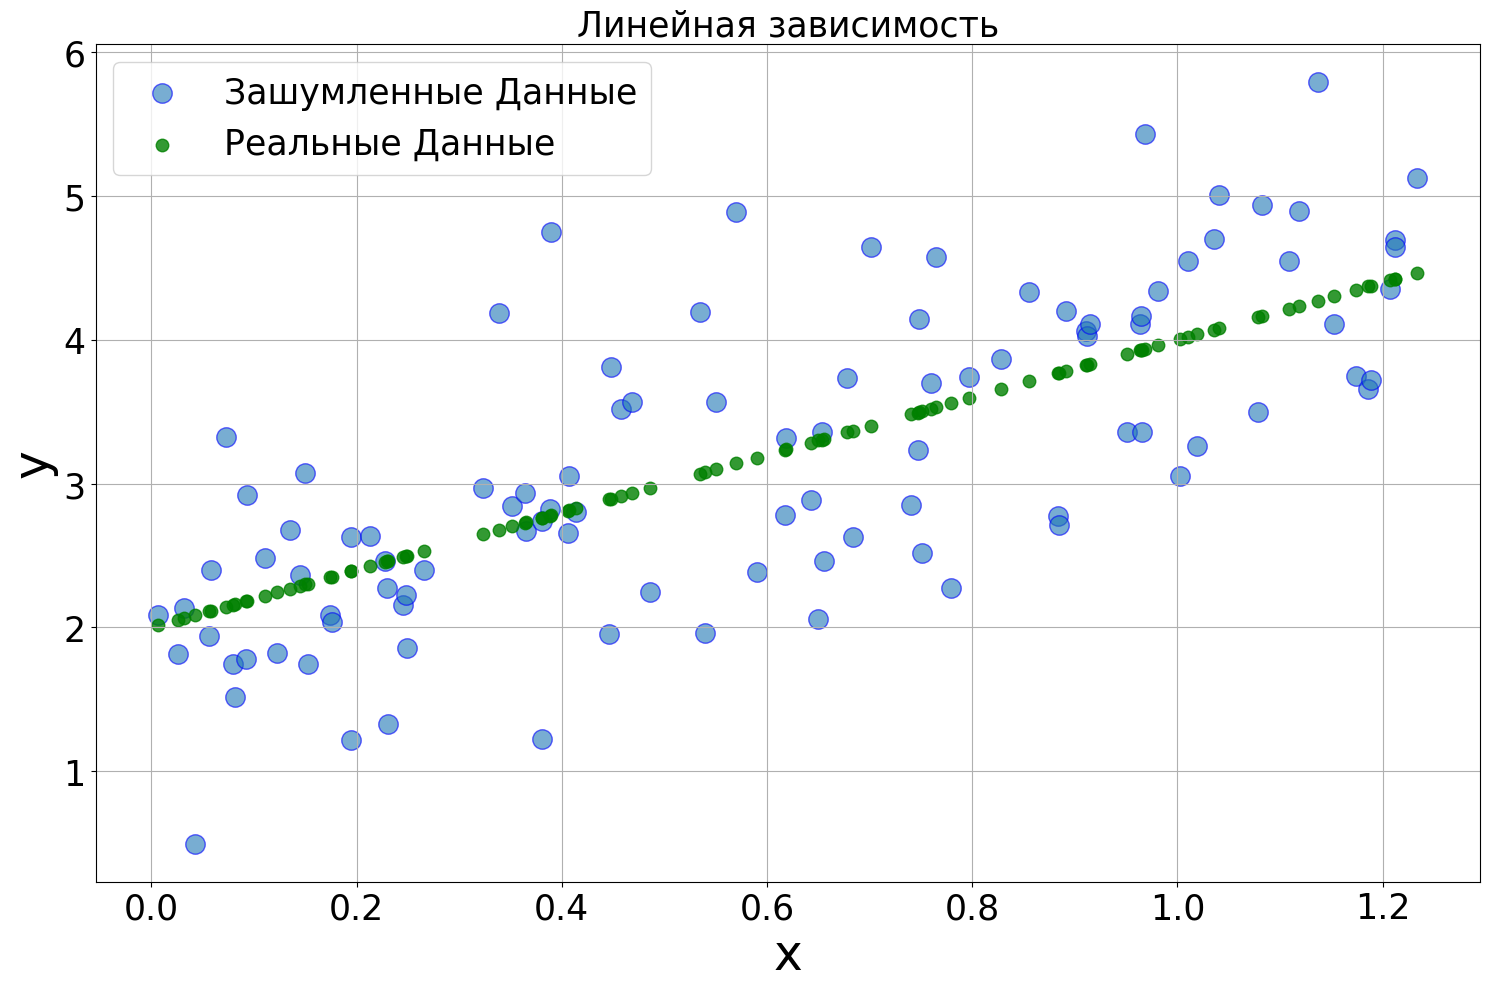

In [36]:
noise_power = 0.80

y, y_true, x = dataset(a = 2, b = 2,
                       f = None,  N = 100,
                       x_max =1.25, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Линейная зависимость')

## Линейная регрессия своими руками

Проведем линейную регрессию. То есть оценим коэффициенты аппроксимации зашумленных данных функцией вида 
$$ \hat{y}_i = \hat{a}x + \hat{b},$$
где $\hat{y}_i$ - это наши оценки значений $y_i$; $\hat{a}$ и $\hat{b}$ - оценинные коэффициенты модели. 

В самом простом случае ( для нашего набора данных) мы могли бы найти коэффициенты $\hat{a}$ и $\hat{b}$ аналитически. Если бы не было шумов (была бы чистая линия), коэффициенты можно найти классическим решением линейной системы из 2 независимых уравнений. В случае шумов 2 уравнений может быть недостаточно. Оценки коэффициентов по каждым двум уравнениям могут различаться. Поэтому желательно иметь переопределенную систему (когда число уравнений больше числа переменных). Такую систему можно решать по-разному. Известно (теорема Гаусса-Маркова), что если шум в системе имеет нормальное распределение, то оптимальным будет решение методом наименьших квадратов. Для поиска такого решения предположим, что мы производим такие оценки коэффициентов $\hat{a}$ и $\hat{b}$, которые дают результат $\hat{y}$ c ошибкой $e$. Ошибку определим как $e_i = y_i- \hat{y}_i$. Теперь наша задача минимизация ошибки $\hat{y}$ для каждого значения $x$. В случае метода наименьших квадратов задача сводиться к минимизации одного значения среднего квадратов ошибки.  <br> Для линейной регрессии такую задачу можно решить аналитически. Однако как можно будет увидеть ниже такое решение не всегда рационально.

В более общем случае, допустим, что мы не знаем как лучше всего аппроксимировать зависимость, какую функцию использовать. Такая ситуация характерна для зависимостей, более сложных чем линейная. В таких случаях можно предположить, что выше указанной модели недостаточно. В более общем случае можно ввести модель целевой переменной как
 $$\begin{align*}
   &y_i = \sum_{j=0}^{m}x_{ij}w_j +\epsilon_i \\ 
   \text{или так }& y_i = 1\cdot w_0 + x_{i1}\cdot w_1 + x_{i2}\cdot w_2 + x_{i3}\cdot w_3 + x_{i4m}\cdot w_4 + \epsilon_i \\
   \text{или так }& y_i = X_i W^T + \epsilon_i , 
   \end{align*}
   $$
где 
<ul>
    <li> $y_i$ - целевой показаль предсказания для $i$ записи в наборе данных;</li>
    <li> $X_i  = \{x_{ij}\}_{j=1}^{m}$ - набор входных параметров для $i$ результата ;</li>
    <li> $W = \{w_{j}\}_{j=1}^{m}$ - набор весовых параметров, которые мы должны подобрать в моделе;</li>
    <li> $\epsilon_i$ - некоторый набор случайных (не объясняемых нашей моделью, остаточных) значений, мы будем считать их случайных шумом.</li>     

Данная модель соответствует как линейной регресии одной или нескольких переменных, так и полиномиальной или любой другой, где состовляющие ($x_{ij}$) можно считать независимыми составляющими.      
В качестве примера регрессионная модель одной переменных будет иметь вид
$$\begin{align*}
   &\hat{y}_i = \sum_{j=0}^{1}x_{ij}w_j  \\ 
   \text{или так }& \hat{y}_i = 1\cdot w_0 + x_{i1}\cdot w_1  \\
   \text{или так }& \hat{y}_i = X_i W^T, 
   \end{align*}
$$
где <ul> 
    <li> $\hat{y}_i $ - результат предсказания для $i$ записи в наборе данных.   </ul>   
        
Теперь рассмотрим решение для обозначенной модели одной переменной.

Введем функцию потерь регрессии `loss_func` как квадрат разности между целевыми значениями и их предсказаниями 
$$ L(\hat{y}_i,y_i)=L_i= (\hat{y}_i-y_i)^2 = \left(\sum_{j=0}^{2}x_{ij}w_j-y_i\right)^2 = \left(X_i W^T-y_i\right)^2 , $$
где  $L_i$ - функция потерь для результата (предсказания) с номером $i$. <br>
Также введем функцию расчета (предсказания) значений `forward`.

Отметим, что для нашего случая одной переменной (в выше приведенных обозначения) решение могло бы быть найдено как 
$$L = \sum_{i=0}^{N-1}(y_i - \hat{y_i})^2 = \sum_{i=0}^{N-1}(y_i - (a\cdot x_i+b))^2 \to 0$$
тогда минимум $L$  будет соответствовать нулям ее производных по `a` и `b`:
$$ \begin{cases}
\frac{\partial{L}}{\partial{a}} = 2\sum_{i=0}^{N-1}(y_i - (a\cdot x_i+b))x_i = 0 \\
\frac{\partial{L}}{\partial{b}} = 2\sum_{i=0}^{N-1}(y_i - (a\cdot x_i+b)) = 0 
\end{cases}
$$
Отсюда решение системы уравнений выглядит как 
$$
\begin{cases}
a = \frac{N\sum xy - \sum x \sum y}{N\sum {x^2} -( \sum x)^2} \\
b = \frac{\sum y - a \sum x}{N}
\end{cases}
$$
В более общем случае мы могли бы записать уравнение как
$$ L =  \sum_{i=0}^{N-1}(y_i - W^TX_i)^2 =0 \text{ или } (y - W^TX)^2 =0$$
тогда
$$\frac{\partial{L}}{\partial{W}} = 2(y - W^TX)X = 0$$
или
$$W=(X^T X)^{-1} X^T y=X^+ y$$
Однако, если массивы $X$ и $y$ достаточно большие, то такое решение оказывается весьма вычислительно сложным. Для больших массивов данных чаще используют численные методы оптимизации. Среди таких методов наиболее зарекомендовал себя метод градиентного спуска. 

Метод градиентного спуска  позволяет итерционно решить задачу оптимизации. В дискурсе данного курса мы будем называть такой процесс оптимизации `обучение`. Каждую итерацию принято называть `эпоха`. Ниже будет показ принцип обучения методом градиентного спуска и его реализация. 

Важно отметить, что особенносью итеративных методов обучения является потенциальная ситуация переобучения/недообучения в ходе оптимизации. Проще всего это представить как ситуацию в которой мы ошибемся в выбранных значениях коэффициентов. Такое явление может происходить если, например, наша модель будет воспренимать все шумы, помехи и искажения входных данных как важные для точного ответа. Другими словами для данных, участвующих  в обучении (`обучающая выборка`) наша ошибка будет стремится к нулю. Однако, для данных, отличных от обучающей выборке точность будет не высокой. Чтобы недопустить этого на каждом шаге обучения мы будем проверять полученные коэффициенты модели. Для такой проверки мы будем использовать т.н. `валидационную` выборку. Как правило валидационная и тренировочная выборки выбирается из одних и тех же данных. В некоторых случаях, кроме данных выборок также может быть и третия выборка, независимая от двух указанных. Такая выборка будет необходима для проверки итоговой точности модели. Выборку можно назвать `тестовая выборка`. По существу, тестова выборка характеризует т.н. `обобщающую способность` то есть разность между точностью на тренировочных данных и данных в которых модель должна работать. Разность значений точности должна быть как можно меньше. 

Для того, чтобы выделить из входных данных тренировочную и тестовую выборку запишем следующую функцию. Функция будет иметь входные аргументы:
* `x,y` - входные данные и метки;
* `train_size` - размер тренировочной части;
* `test_size`  - размер тестовой части;
* `random_state` - состояние генератора случайных чисел; 
* `shuffle` - необходимость перемешивания данных.

In [55]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


x_train, y_train, x_val, y_val, x_test, y_test = train_test_split(x, y, train_size = 0.5, test_size=0.3, )    
print(f" Размер выборки для обучения {x_train.shape}, \n размер целевой переменной для обучения {y_train.shape}, \n размер выборки для валидации: {x_val.shape}, \n размер целевой переменной для валидации: {y_val.shape},  размер выборки для тестирования {x_test.shape}, размер целевой выборки для тестирования {y_test.shape}\n \n ")

    
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(f" Размер выборки для обучения {x_train.shape}, \n размер целевой переменной {y_train.shape}, \n Размер выборки для тестирвания {x_test.shape, y_test.shape}")



 Размер выборки для обучения (50, 1), 
 размер целевой переменной для обучения (50,), 
 размер выборки для валидации: (20, 1), 
 размер целевой переменной для валидации: (20,),  размер выборки для тестирования (30, 1), размер целевой выборки для тестирования (30,)
 
 
 Размер выборки для обучения (70, 1), 
 размер целевой переменной (70,), 
 Размер выборки для тестирвания ((30, 1), (30,))


In [38]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )


(70, 1) (70,) (30, 1) (30,)


Перед началом процедуры обучения модели запишем функцию инициализации весовых параметров (коэффициентов модели). Данная функция будет создавать случайный массив весовых параметров с нормальным распределением, имеющим `0` среднее разброс  значений $1/\sqrt{weight.size}$. Также мы будем иметь возможность создавать набор весов с учетом смещения. То есть, если `add_bias = True`, то  размер выходного массива на `1` больше, чем размер признаков входных данных (в нашем случае входные данные имеет `1` признак- значения, а число параметров будет `2`: коэффициент при значении и смещение). Значения смещения проинициализируем нулями.

In [56]:
def init_weights(W_shape, add_bias = True, random_state = 42):
    W_shape = np.atleast_1d(W_shape)
    if random_state: 
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape))/np.sqrt(np.sum(W_shape))
        
    if add_bias: 
        W = np.column_stack((np.zeros(W.shape[-1]),W ))
    return W.squeeze()


Запишем функции предсказания и расчета значений функции потерь. Отметим, что для учета смещения мы будем добавлять единичный столбец к входным данным.

In [57]:
def predict( X, W, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return  np.dot(X_full,W)

def loss_func(yhat, y):
    return np.square(yhat - y)  

Протестируем функции. 

In [41]:
x_train[:1]

array([[1.01049669]])

In [58]:
weights = init_weights(x.shape[1])
yhat = predict( x_train[0],weights)
loss = loss_func(yhat, y[0])

print(f'{weights}')
print(f'predict {yhat},\nground truth {y[0]},\nloss: {loss}')

[0.         0.49671415]
predict [0.50192801],
ground truth 2.083442947399543,
loss: [2.50118951]


Посмотрим на график того как меняется функция потерь в зависимости от отклонения (мультипликативного) оценки результата от его истинного значения.

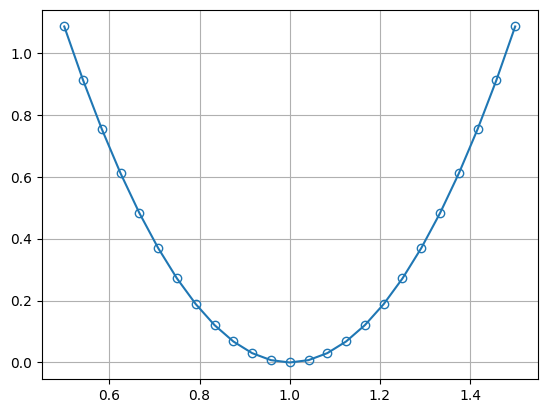

In [59]:
decline = np.linspace(start = 0.5, stop = 1.5,num = 25)

yhat = decline * y[0]

loss = loss_func(yhat, y[0])

plt.plot(decline,loss,'-o', mfc = 'none'); plt.grid(); 

Сразу отметим, что нам потребуется не только сама фунция потерь, но и ее производная по набору оптимизируемых параметров $\{w_j\}$.   
$$\frac{\partial L_i}{\partial w_j} = 2\left(\sum_{j=0}^{m}x_{ij}w_j-y_i\right)x_{ij} = 2(\hat{y}_i - y_i)x_{ij},$$
где  $\frac{\partial L_i}{\partial w_j}$ - частная производная функции $L_i$ по параметру $w_j$  <br>   
тогда по набору всех переменных мы получим производную вида:
$$\nabla_{W}L_i  = 2(\hat{y}_i-y_i)\odot X_i,  $$
 где <ul> 
    <li> $\nabla_{W}L_i$ - градиент, то есть набор частных производных функции $L_i$ по набору \{$w_j$\}.  
    <li> $\odot$ - операция поэлементного умножения (умножение Адамара)    

In [60]:
def grad_loss(y_hat, y, X, add_bias = True):
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]),X))
    else:
        X_full = X
    return 2*np.dot(X_full.T, (y_hat - y)) / y.size  

Проведем расчет градиента ошибки

In [61]:
yhat = predict(x_train[0], weights)

grad = grad_loss(yhat, y[0], x[0])
print(grad)

[-3.16302988 -0.02183328]


Опимизацию мы будем проводить методом градиентного спуска. <br>
По сути этот метод сводится к последовательному (итерационному) пересчету значений весовых параметров обратно значеням градиента ошибки (то есть в направлении, обратном направлению роста ошибки).
<br> Обозначим номер итерации как  $t$, тогда выражение для обновления весовых параметров можно записать как: 

$$ W^t = W^{t-1}-\eta\nabla_{W}L(\hat{y}_i,y_i)=W^{t-1} - 2\eta (\hat{y}_i-y_i)\odot X_i^T  $$

где <ul>
<li> $\eta$ - коэффициент с которым изменяются значения весовых параметров - т.н. скорость обучения;



In [62]:
def update_weights(grad, W, learning_rate):
    return W - learning_rate*grad

теперь проведем обновление весовых параметров

In [63]:
learning_rate = 0.1
weights = update_weights(grad, weights, learning_rate)
print(weights)

[0.31630299 0.49889748]


In [64]:
yhat = predict( x_train[0],weights)
loss = loss_func(yhat, y[0])

print(f'{weights}')
print(f'predict {yhat},\nground truth {y[0]},\nloss: {loss}')

[0.31630299 0.49889748]
predict [0.82043724],
ground truth 2.083442947399543,
loss: [1.59518342]


Также создадим процедуру обучения. Процедура будет повторять порцесс пересчета весов методом градиентного спуска заданое число раз (epochs).<br> 
Функция будет требовать на вход <ul>
    <li> $X$ - набор входных значений (т.н. батч ) в формате: $\textrm{число записей}\times\textrm{значения в записи}$;
    <li> $y$ - набор целевых переменных (labels);   
    <li> $weights$ - начальные значения весовых параметров;
    <li> $lr$ - скорость обучения ($\eta$);    
    <li> $epochs$   -  число эпох обучения.
        </ul>
Функция дает на выходе:<ul>
    <li> $weights$ - набор обученных весовых параметров;
    <li> $cost$    - график функции потерь.
 </ul>
Также отметим, что на практике мы можем обновлять весовые параметры не для кажого отдельного значения $i$, а для целого набора таких значений, тогда более верное выражение будет выглядеть как

$$ W^t = W^{t-1}-\eta\frac{1}{n}\sum_{i=0}^{n-1}\nabla_{W}L(\hat{y}_i,y_i),  $$
где $n$ - объем выборки.        

In [65]:
def fit(X, y, learning_rate, weights = None,  epochs=30):

    if weights is None: weights = init_weights(X.shape[1])
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        yhat    = predict(X,weights)
        grad    = grad_loss(yhat,  y, X) 
        weights = update_weights(grad, weights, learning_rate)  
        cost[i] = loss_func(yhat,  y).mean()
                
    return weights, cost

Протестируем обучение

In [66]:
weights, cost = fit(x_train, y_train, learning_rate=0.1, epochs=10)


In [67]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks(fontsize = 25)

    plt.yticks(fontsize = 25);  

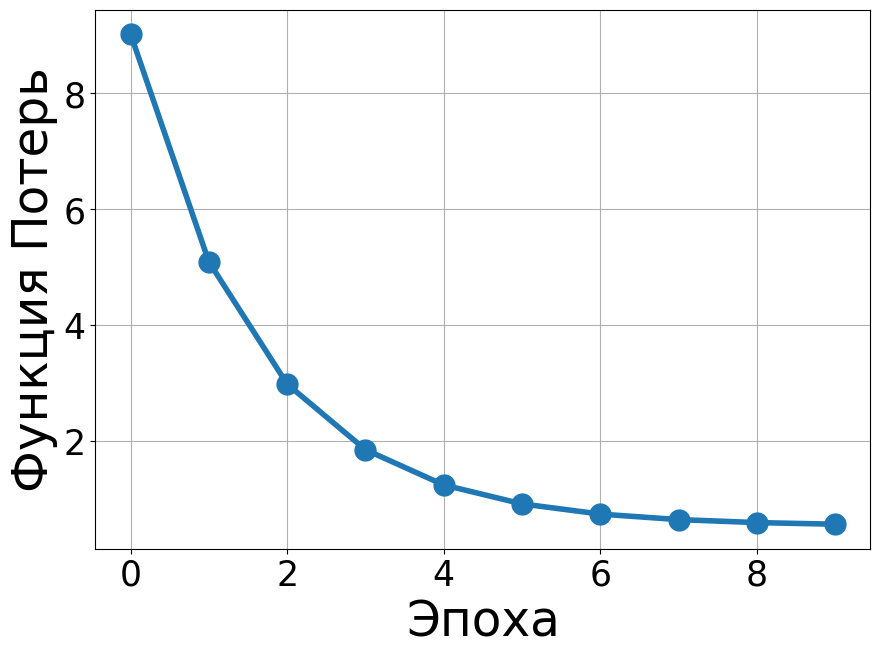

In [68]:
fig  = plt.figure(figsize=(10,7))

plot_cost(cost)


Теперь проверим как точно предсказывает наша функция, для этого мы можем воспользоваться метрикой $R^2$, метрика соотвествует относительной среднеквадратичной ошибке, она может быть расчитана как:
$$
R^2 = 1-\frac{\sum_{i=0}^{n-1}(y_i - \hat{y}_i)^2}{\sum_{i=0}^{n-1}(y_i - \mathrm{ev}(y))^2} = 1 - \frac{SS_{\rm res}}{SS_{\rm tot}},
$$
где 
<ul>
    <li>$SS_{\rm res} = \sum_{i=0}^{n-1}L_i = \sum_{i=0}^{n-1}(y_i - \hat{y}_i)^2$ сумма квадратов остатков, величина, характеризующая степень того на сколько наша модель не соответствует нашим данным - то есть то, на сколько мы не можем объяснить нашей моделью наши данные;</li>
    <li>$SS_{\rm tot}$ - дисперсия данных - то есть сумма квадратов разностей значений данных и их среднего значения;</li>
    <li>$\mathrm{ev}(y) = \frac{1}{n}\sum_{i=0}^{n-1}y_i$ - среднее значение.</li>  
</ul>  

Отметим, важное обстоятельство. Для расчета градиента мы использовали функцию потерь. Однако, для оценки качества модели мы пользуемся другой функцией метрикой. Дело в том, что значения функции потерь, сколь небольшими бы они нибыли, очень сложно интерпретировать. Более того, можно ожидать, что для другого метода оптимизации значения могли быть и другими. Таким образом значения функции потерь не подходят для оценки качества модели.  Качество работы модели как правило определяется по некоторым метрикам. Такие метрики должны быть интерпретируемыми и едиными для всех сравниваемых оценщиков. В нашем случае метрика соответствует среднему квадрату ошибки в %. Тогда результат работы метрики мы можем интерпретировать как средняя ошибка предсказания для нашей модели. Чем ниже эта ошибки (для разных моделей), тем лучше.

In [69]:
def r2_score(yhat, y):    
    return 1-(np.square(y-yhat)).sum(axis=0)/(np.square(y-np.mean(y, axis=0))).sum(axis=0)

In [70]:
predicts = predict( x_test,weights,)

r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)

(0.4045482809412886, 0.5664398712231291)

Посмотрим на то, какая интерпретация может быть у предсказанных и заданных данных. 

In [71]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    plt.plot(x_train[:,0], predict(x_train,weights, ),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], predict(x_test,weights, ),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);

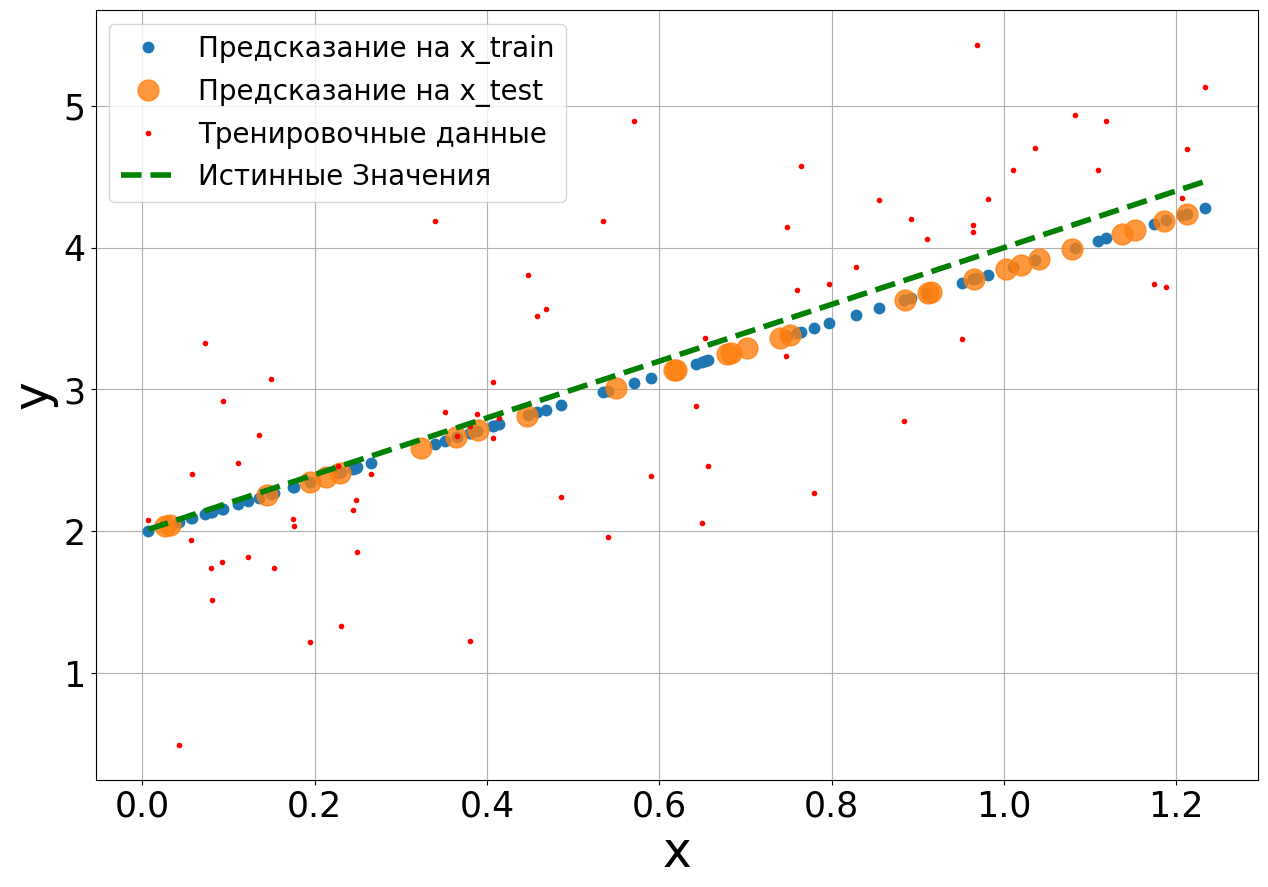

In [72]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, x, y_true, weights)

In [ ]:
weights

array([2.04548417, 1.55145866])

In [73]:
def vis_weigths(weights):
    numbers = np.arange(0,len(weights))
    tick_labels = ['w'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels );

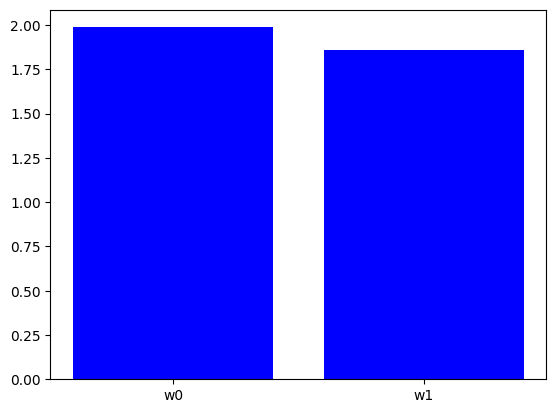

In [74]:
vis_weigths(weights)

На практике как правило, на каждой эпохе рассматривается не вся выборка, а только некоторая ее часть - т.н. батч (мини пакет). 
Запишем функцию для генерации минибатчей заданного размера.

In [75]:
def load_batch(X,y, batch_size = 100):
    idxs = np.arange(y.size)
    np.random.shuffle(idxs)

    for i_batch in range(0,y.size,batch_size):
        idx_batch = idxs[i_batch:i_batch+batch_size]
        x_batch   = np.take(X, idx_batch,axis=0)
        y_batch   = np.take(y, idx_batch)
        yield  x_batch, y_batch

Также запишем функцию оптимизации методом стохастического градиентного спуска.

In [76]:
BATCH = 10

def fit_SGD(X, y, lerning_rate, weights = None,  epochs=30, batch_size = 100, random_state = 42):
    
    if random_state: np.random.seed(random_state)

    if weights is None: weights = init_weights(X.shape[1])
    if batch_size is None or batch_size>y.size : batch_size = y.size
    n_batches = y.size//batch_size
    
    cost    = np.zeros(epochs)

    for i in range(epochs): 
        loss = 0
        for cnt,(x_batch, y_batch) in enumerate(load_batch(X,y, batch_size)): 

            yhat    = predict(x_batch, weights)
            grad    = grad_loss(yhat,  y_batch, x_batch) 
            weights = update_weights(grad, weights, lerning_rate) #backward 
            loss   += loss_func(yhat,  y_batch).mean()

            if cnt>= n_batches:
                break
        cost[i] = loss/n_batches

    return weights, cost

In [77]:
weights = init_weights(x_train.shape[1], random_state=42)

weights, cost = fit_SGD(x_train, y_train, lerning_rate=0.1, batch_size = 10,  epochs=10)

predicts = predict(x_test, weights, )
r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)

(0.37539675964150176, 0.6000486615027569)

In [78]:
weights

array([1.88926863, 2.21742144])

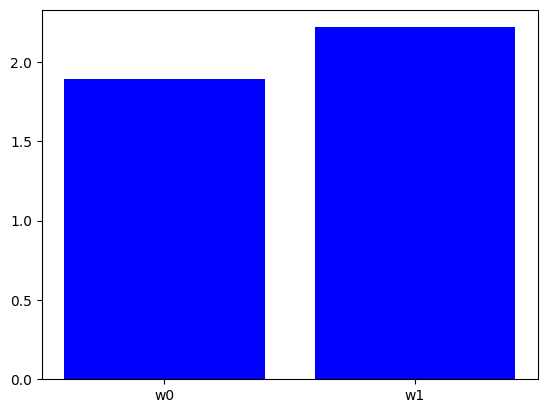

In [79]:
vis_weigths(weights)

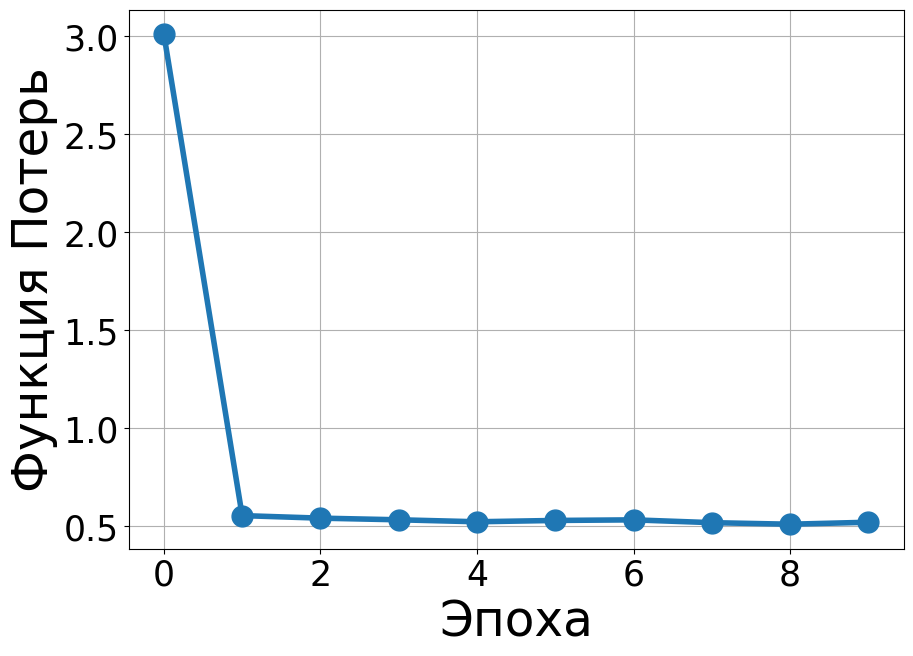

In [80]:
fig  = plt.figure(figsize=(10,7))

plot_cost(cost)




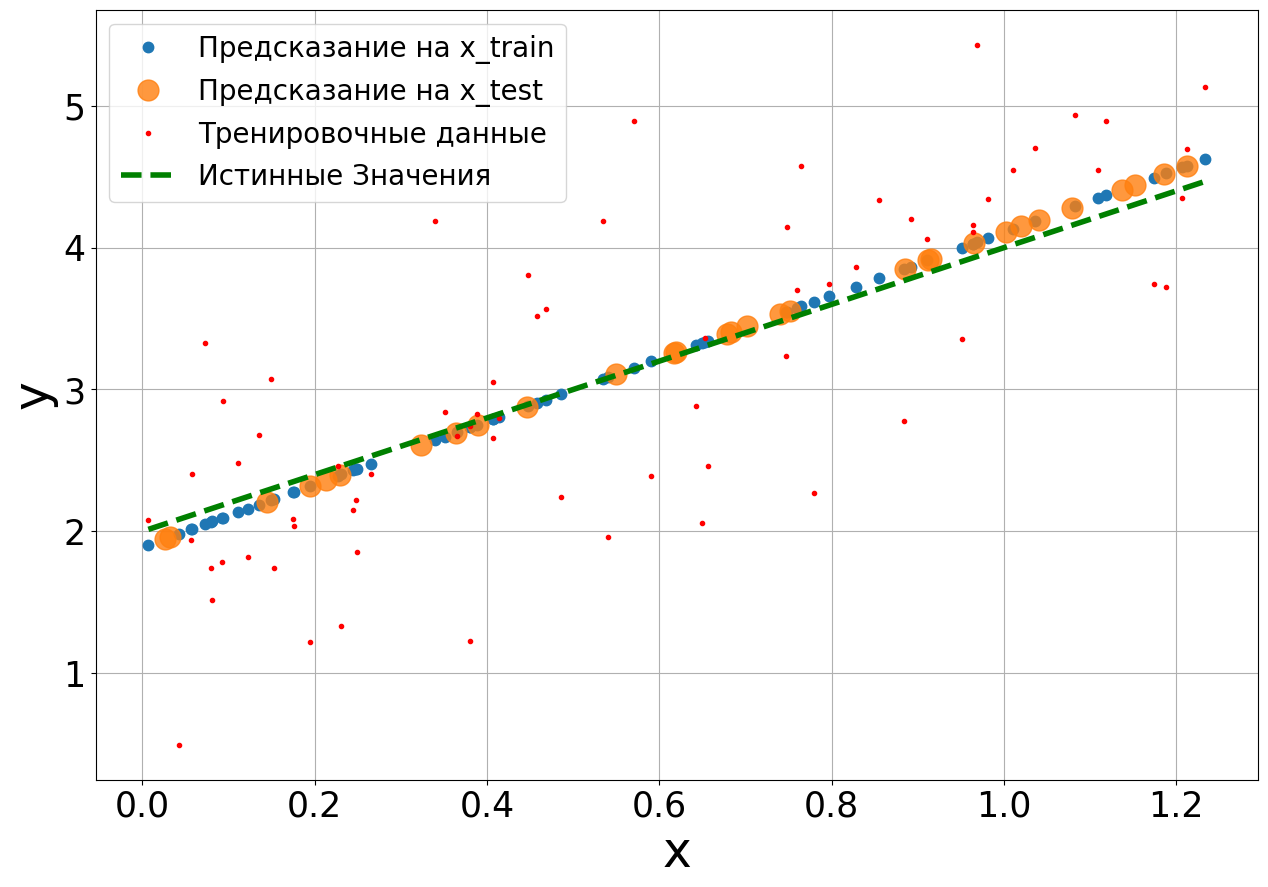

In [81]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, x, y_true, weights)

Теперь давайте объеденим все наши части в один класс линейной регресии.
<!-- <br> При объединении мы сделаем две дополнительные модификации нашей модели.
<ul>
    <li> во-первых, введем в модель дополнительный член - смещение ($b$), тогда можно записать модель так:
        $$\begin{align*}
        &\hat{y}_i = \sum_{j=0}^{M-1}x_{ij}w_j+b \\
        \text{   или так: }&\hat{y}_i = \sum_{j=0}^{M}x_{ij}w_j, x_{i0} \equiv 1.
        \end{align*}$$
        обе запси формально равнозначны. <ul>
        при этом отметим, что градиент функции потерь по остаточному члену можно записать следующим образом:
        $$b^t = b^{t-1}-\eta\nabla_{b}L(\hat{y}_i,y_i)=b^{t-1} - 2\eta(\hat{y}_i-y)$$
        </ul>
        Мы будем использовать второй вариант, то есть объеденим веса и смещния, а к данным добавим столбец едениц.
<li> Во воторых запишем все обозначенные функции в один класс.
<li> В третьих проведем векторизацию в тех местах, где у нас стояли лишнии циклы.
    <br> В том числе отметим, что выражение для расчет суммарного градиента может быть записано векторно в следующей форме
    $$2\sum_{i=0}^{M-1}(\hat{y}_i-y_i)\odot X_i^T = 2 X_i^T(\hat{y}-y), $$ 
    где $\hat{y}, y$ - массивы значений оценок и целевых результатов.
     -->

In [82]:
import numpy as np

class LinearRegression():
    def __init__(self, 
                 X,
                 learning_rate = 0.5, 
                 epochs = 100,  
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self, yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self, yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad = np.zeros(self.weights.shape)
        self.cost = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]

    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

# Полиномальная Зависимость

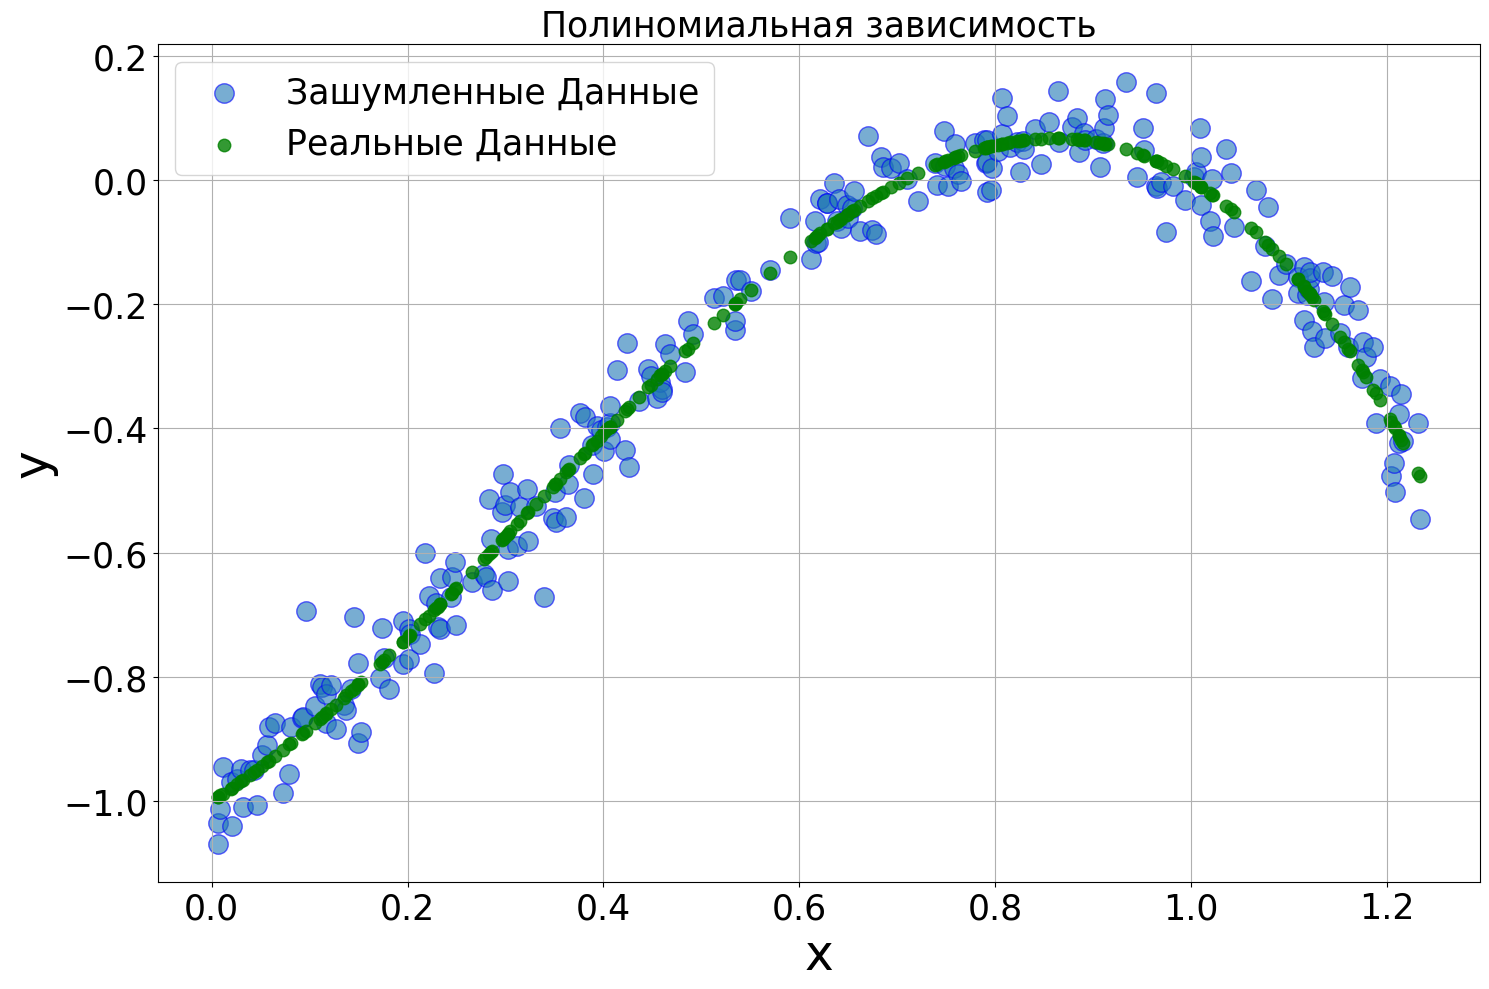

In [83]:
noise_power = 0.05

y, y_true, x = dataset(a = [1, 2, -2], b = -1,
                       f = None,  N = 250,
                       x_max =1.25, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Полиномиальная зависимость')

In [84]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3)    

In [86]:
regr_poly_lin = LinearRegression(
                        X = x_train,
                        learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)
regr_poly_lin.fit(x_train, y_train)

In [89]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);

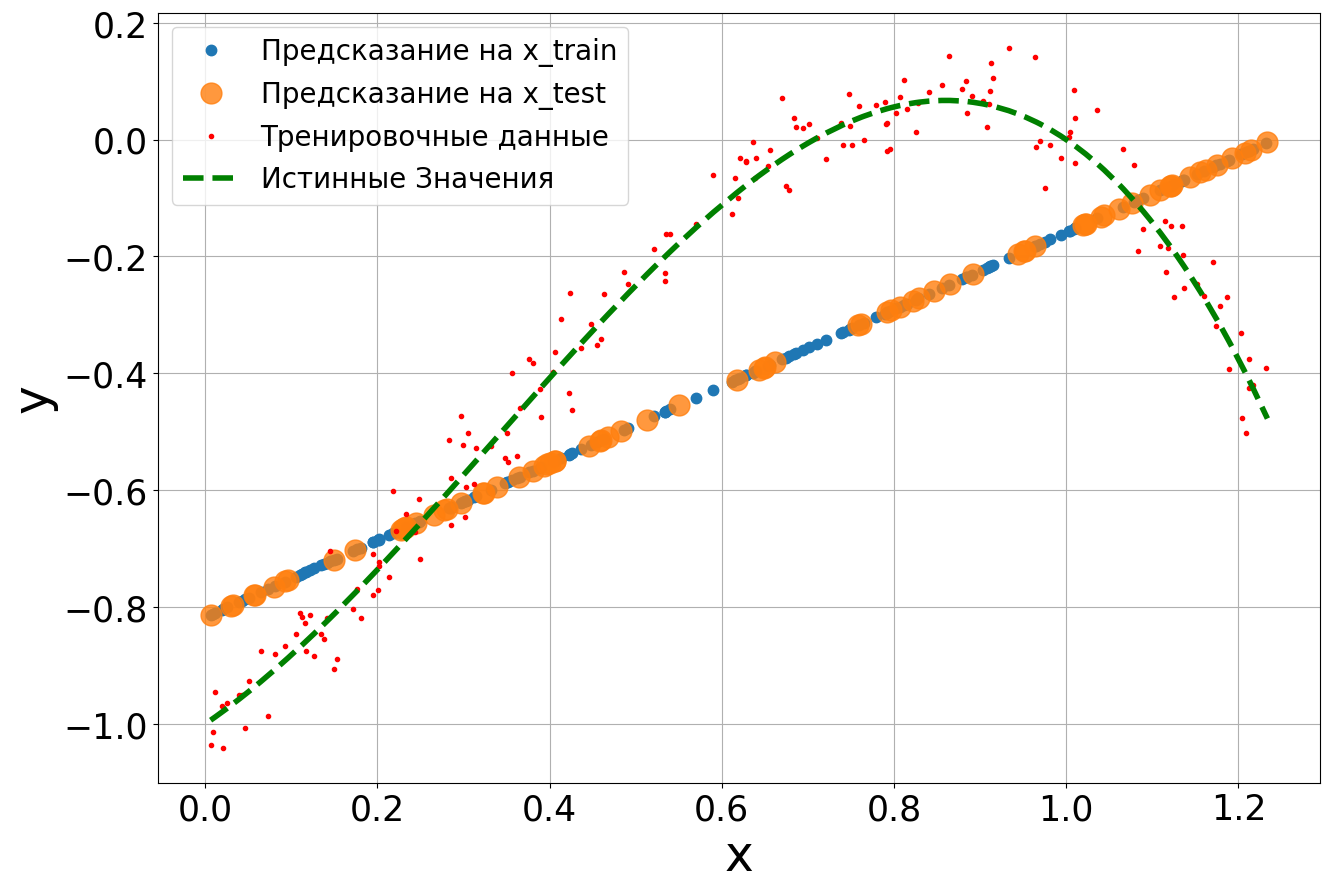

In [90]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly_lin)

Теперь попробуем реализовать полиномиальную регрессию. 
Как известно члены полиномов различных целых степеней можно считать независимыми функциями. Поэтому 
регрессия может быть представлена как многопеременная линейная регрессия. 

Для реализации давайте запишем функцию `to_polynom` создающую полином из входных данных `x`. Выход функуции будет массив, имеющий число столбцов, равное степени искомого полинома. 

In [92]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T


In [112]:
x_ = to_polynom(x, order = 5) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3, )

In [113]:
regr_poly = LinearRegression(
                        X = x_train,
                        learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

In [114]:
regr_poly.fit(x_train, y_train)

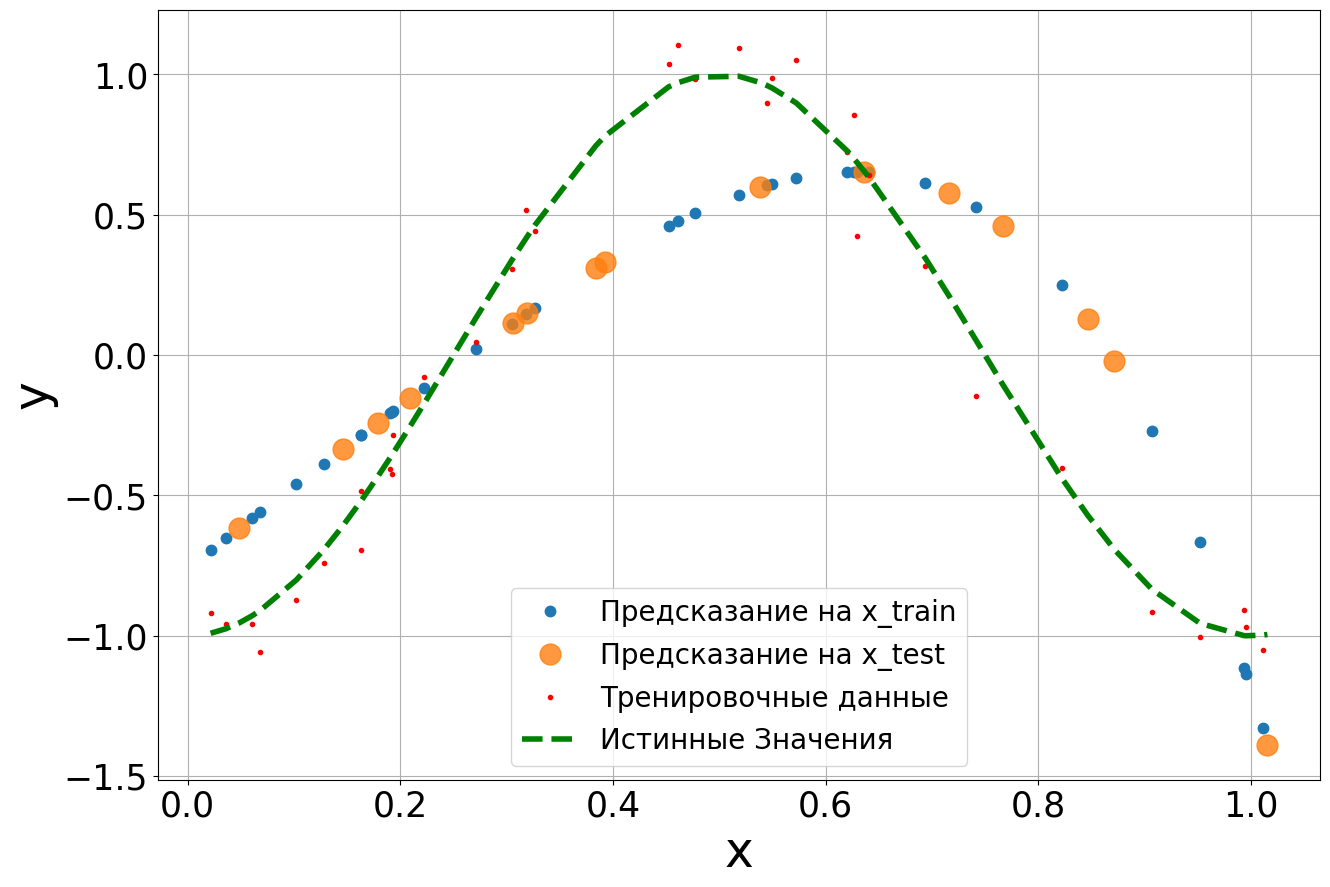

In [115]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)


# Посмотрим, как это все будет выглядеть на гармонических данных

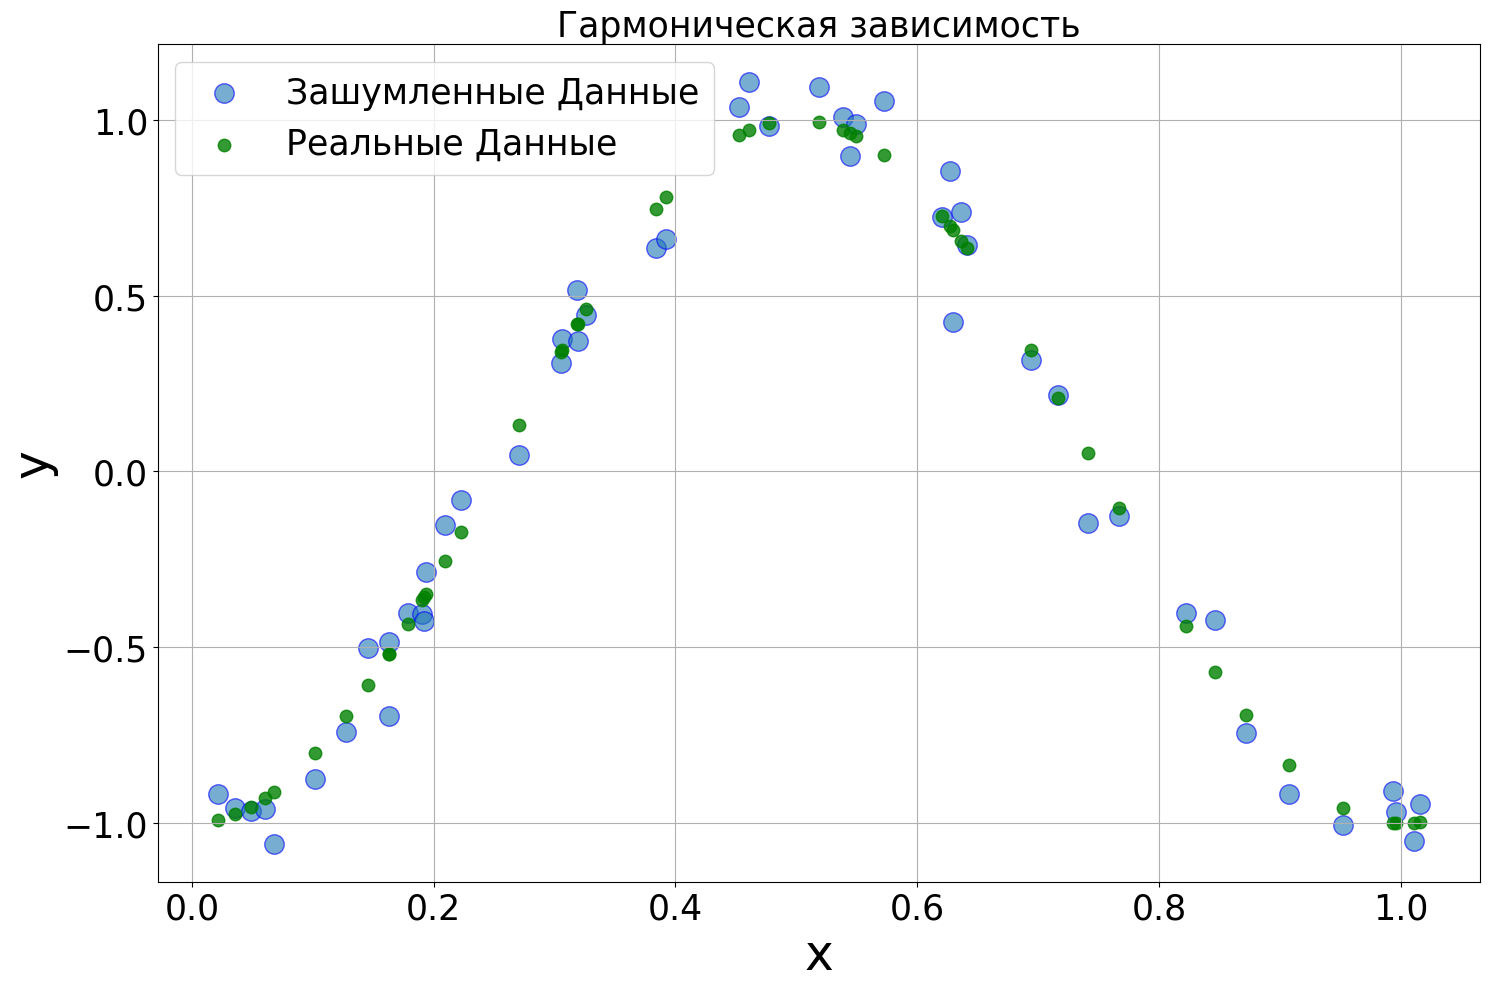

In [116]:
y, y_true, x = dataset(a = 2*np.pi,
                       b = np.pi, f = np.cos,  
                       N = 50, x_max =np.pi/3, 
                       noise_power = 0.1, seed = 42)
vis_data(y, y_true,x, 'Гармоническая зависимость')

In [117]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(35, 1) (35,) (15, 1) (15,)


Train Score = 0.00


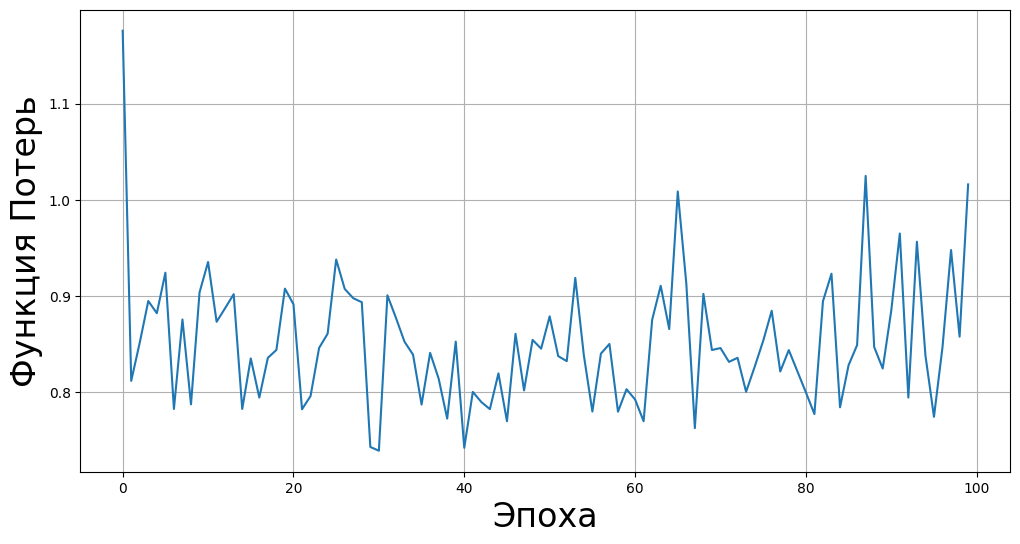

In [118]:
regr_harm = LinearRegression(
                        X = x_train,
                        learning_rate=0.25,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_harm.fit(x_train, y_train)

print(f'Train Score = {regr_harm.score(x_train, y_train):.2f}')
regr_harm.plot_cost()

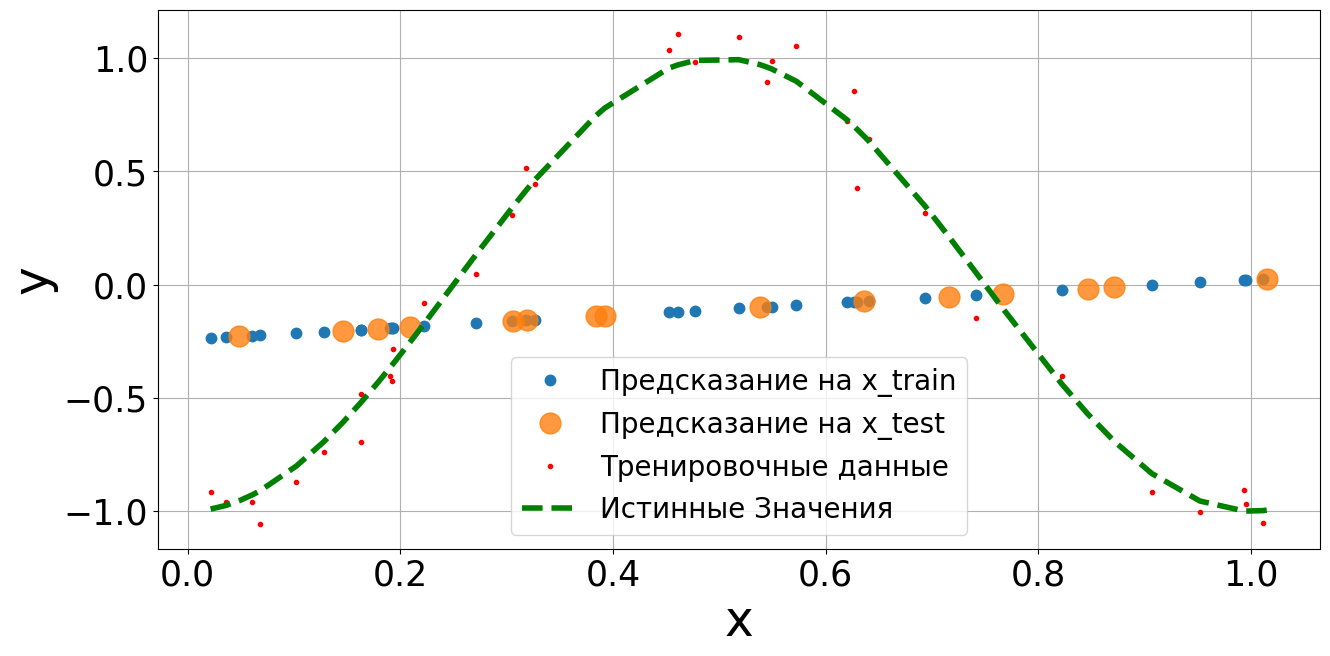

In [119]:
fig  = plt.figure(figsize=(15,7))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_harm)

In [120]:
w, b = regr_harm.get_w_and_b()
print(w,b)

[0.26398754] -0.24167518488441947


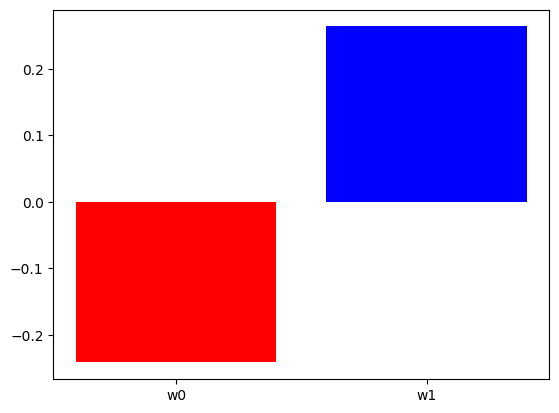

In [111]:
vis_weigths(np.hstack([b,w]))

## Полиномиальная регрессия


Создадим наш набор данных

In [121]:
order  = 10

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)


pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9
31,0.190407,0.036255,0.006903,0.001314,2.502711e-04,4.765328e-05,9.073502e-06,1.727655e-06,3.289571e-07,6.263562e-08
32,0.640731,0.410536,0.263043,0.168540,1.079887e-01,6.919167e-02,4.433324e-02,2.840567e-02,1.820039e-02,1.166155e-02
33,0.036012,0.001297,0.000047,0.000002,6.056345e-08,2.180985e-09,7.854071e-11,2.828375e-12,1.018542e-13,3.667931e-15
34,0.326423,0.106552,0.034781,0.011353,3.705990e-03,1.209721e-03,3.948808e-04,1.288982e-04,4.207534e-05,1.373436e-05


Test Score = 0.41, Train Score = 0.68


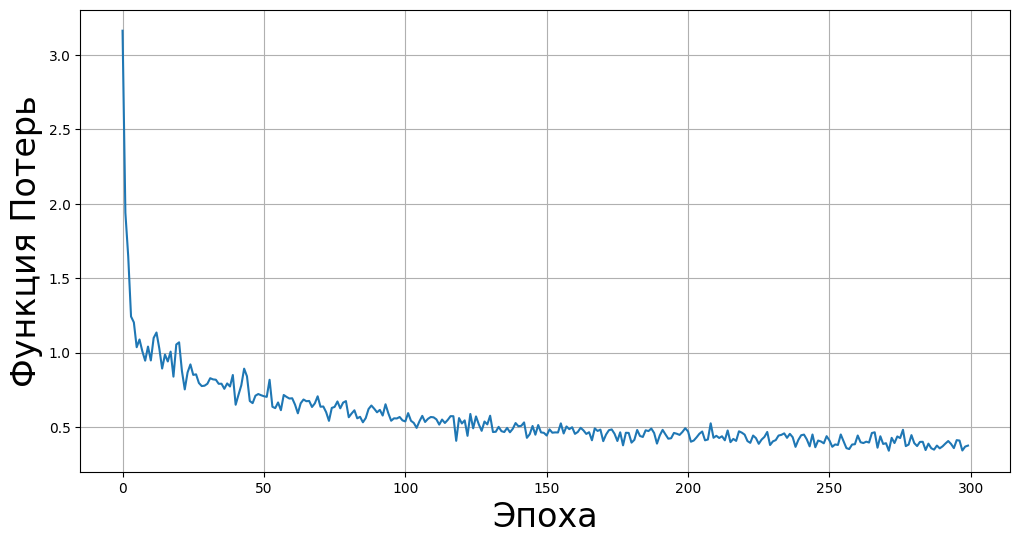

In [122]:
regr_harm_poly = LinearRegression(
                        X = x_train,
                        learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly.fit(x_train_, y_train)
print(f'Test Score = {regr_harm_poly.score(x_test_, y_test):.2f}, Train Score = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()



In [123]:
w, b = regr_harm_poly.get_w_and_b()
print(w,b)

[ 2.10780575  0.42714302 -0.17405947 -0.2311899  -0.85745282 -0.80629031
 -0.13060886 -0.26815298 -0.53928071 -0.10548005] -0.6665371994488513


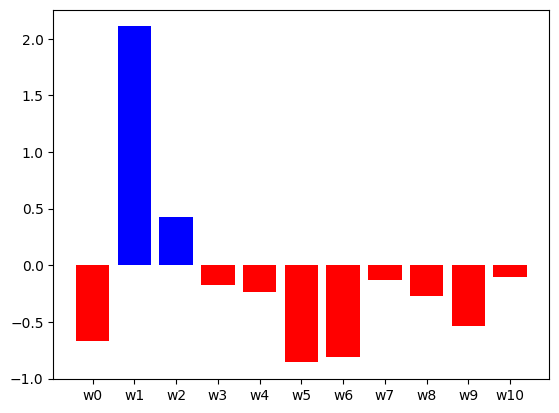

In [124]:
vis_weigths(np.hstack([b,w]))

In [125]:
np.sum(np.abs(w))

5.647463879933974

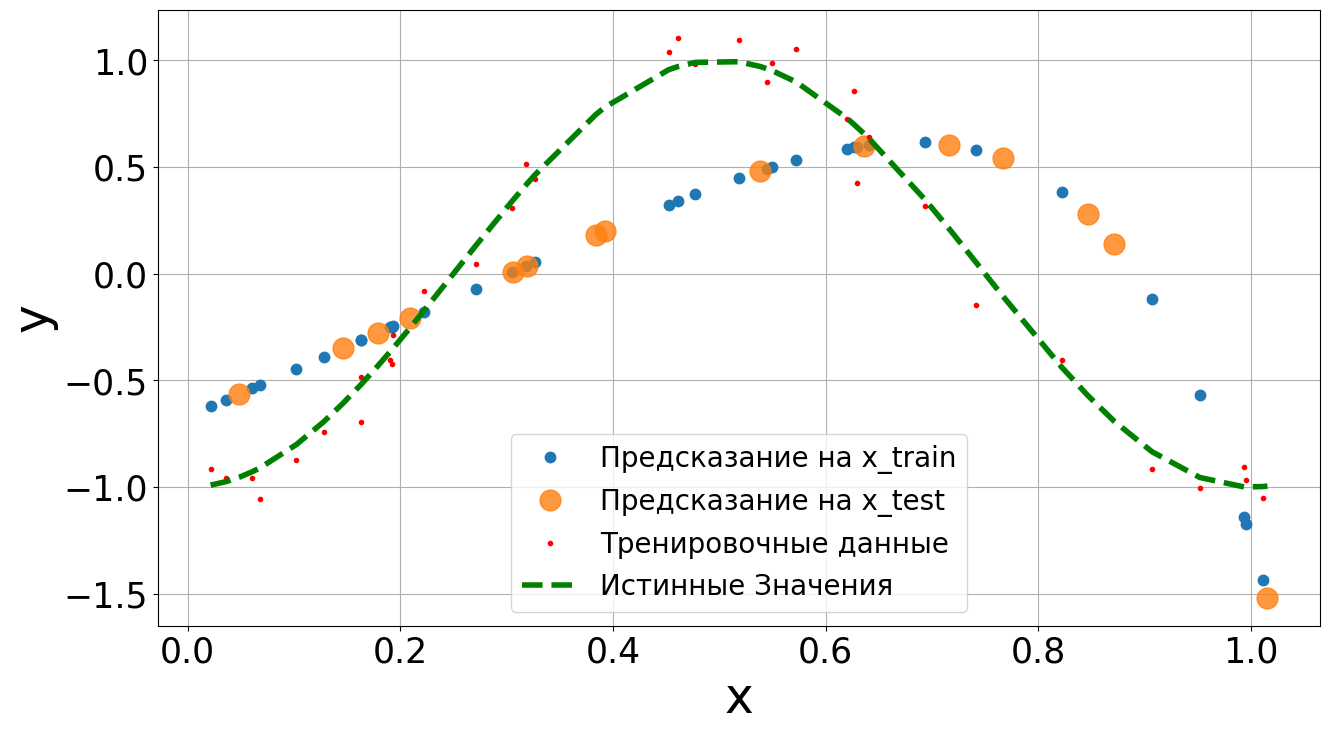

In [126]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_harm_poly)

Как видно из таблицы наши данные имеют слегка  разный масштаб. Чтобы было, если бы мы взяли более высокие порядки? Для компенсации этого эффекта часто для данных применяют перемасштабирование - нормализацию. Этот процесс можно описать следующим выражением:
$$ x' =\frac{x - \min(x)}{\max(x) - \min(x)}$$

Давайте попробуем посмотреть к чему это приводит

In [127]:
class MinMaxScaler:
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [128]:
class StandardScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [129]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

In [130]:
pd.DataFrame(x_test_scaled).tail(4)

,0,1,2,3,4,5,6,7,8,9
11,1.290826,1.314799,1.202790,1.042037,0.873383,0.713301,0.567758,0.438375,0.324924,0.226372
12,-0.818138,-0.806942,-0.701026,-0.607631,-0.541376,-0.496097,-0.464670,-0.442123,-0.425319,-0.412306
13,0.271678,-0.030467,-0.232614,-0.342675,-0.395187,-0.416225,-0.421213,-0.418529,-0.412527,-0.405378
14,0.860650,0.673987,0.441925,0.236037,0.072468,-0.051594,-0.143407,-0.210200,-0.258052,-0.291783


Test Score = 0.97, Train Score = 0.95


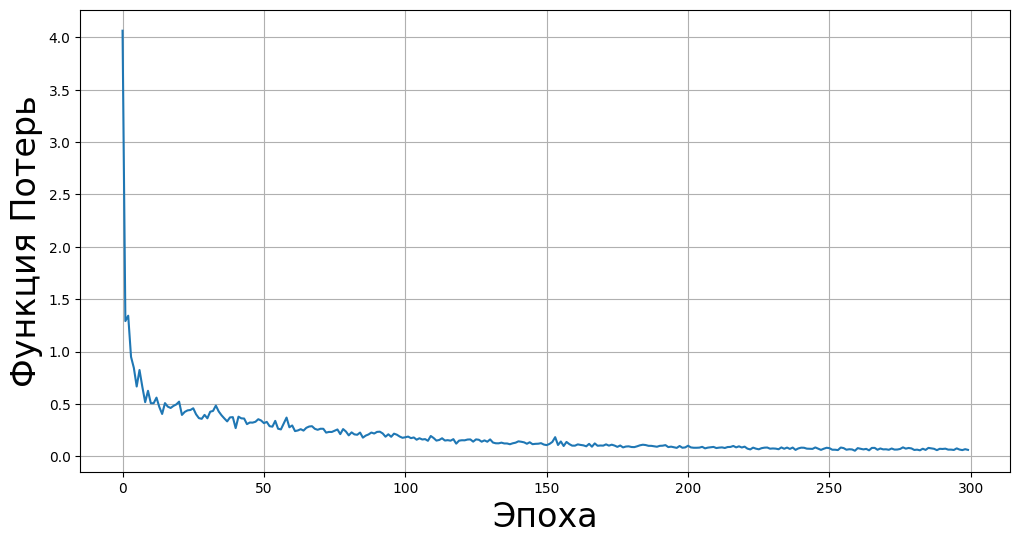

In [132]:

regr_harm_poly_scale = LinearRegression(
                        X = x_train,
                        learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()



In [133]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[ 1.73051734 -0.26424088 -0.76261794 -0.58089313 -0.93862771 -0.63683296
  0.2562212   0.30131014  0.18156999  0.74026176] -0.060247959119143275


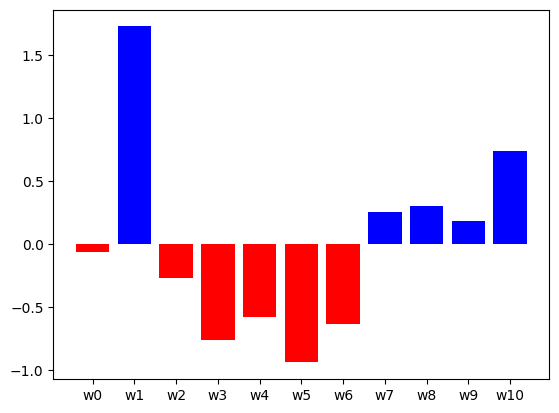

In [134]:
vis_weigths(np.hstack([b,w]))

In [135]:
np.sum(np.abs(w))

6.393093053065999

Посмотрим на результат.

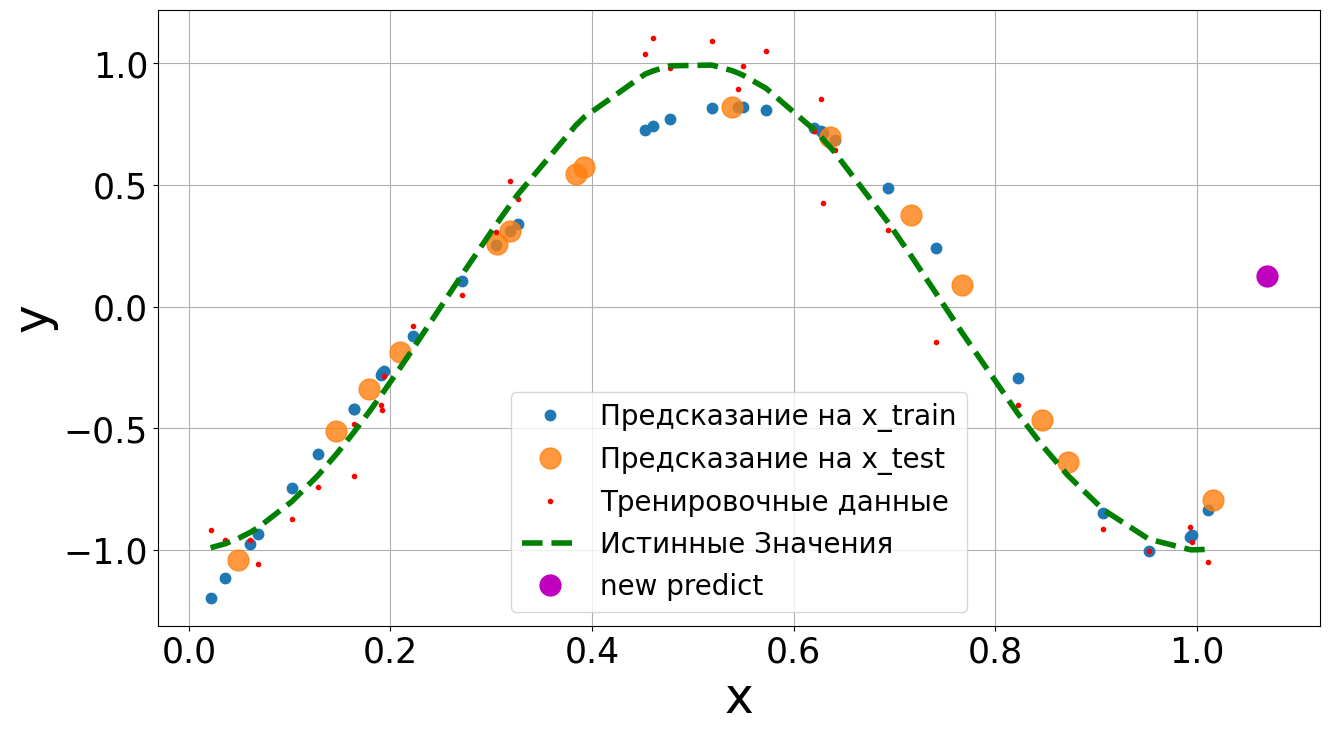

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')

plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'new predict',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25);



# Метод Наименьших Квадратов 

Для более детального сравнения давайте также посмотрим на аналитическое решение проблемы.

In [ ]:
order = 10
x_train_ls = to_polynom(x_train, order=order, add_bias=True)
x_test_ls  = to_polynom(x_test,  order=order, add_bias=True)
weights  = np.linalg.lstsq(x_train_ls, y_train, rcond=None)[0] #включая смещение

In [143]:
weights

array([-8.69971720e-01, -1.05350795e+00, -9.49283445e+01,  1.99165390e+03,
       -1.41545730e+04,  5.41571702e+04, -1.24039972e+05,  1.74367054e+05,
       -1.47329953e+05,  6.86886777e+04, -1.35841838e+04])

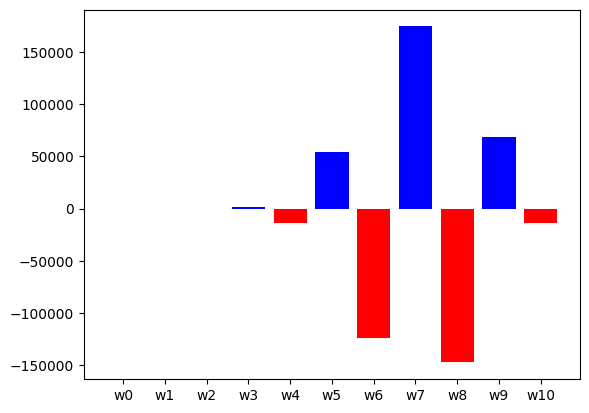

In [149]:
vis_weigths(weights)

In [150]:
np.sum(np.abs(weights))

598410.0894042187

$$\sum_i{x^i*w_i}$$

In [151]:
def polyval(x,weights):
    return np.sum([np.power(x,i)*wi for i, wi in enumerate(weights) ],axis = 0) # c добавлением смещения

In [152]:
print(f"Test score: {r2_score(y_test, polyval(x_test,weights).squeeze()):.2f}, Train score: {r2_score(y_train, polyval(x_train,weights).squeeze()):.2f}")


Test score: 0.98, Train score: 0.99


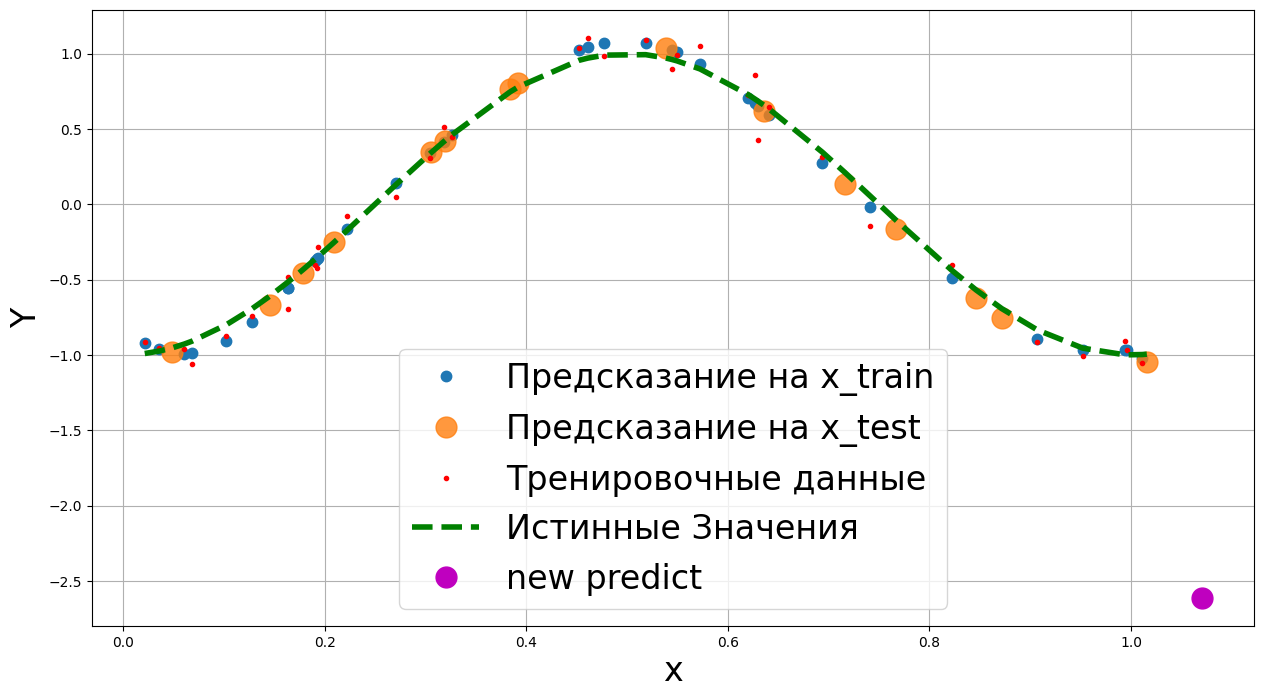

In [153]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], polyval(x_train, weights),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], polyval(x_test, weights),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         polyval([1.07], weights), 
         'mo',  label = 'new predict',
        markersize = 15 )

plt.grid()
plt.legend(fontsize = 24)
plt.xlabel('x', fontsize = 24)
plt.ylabel('Y', fontsize = 24)
plt.show()

Аналитическое решение методом наименьших квадратов дало результаты лучше чем численное

Однако, градиентный спуск позволяет поднять точность на тестовых данных.

## Регуляризация линейной регрессии

### Регуляризация Тихонова

Часто бывает так, что обычный градиентный спуск приводит к переобучению модели. Переобучение это ситуация, когда точность на обучающих данных значительно выше, чем на тестовых.

В таких случаях также можно сказать, что данные плохо обусловлены - то есть любые небольшие изменения по отношению к тренировочной выборке приведут к большим изменениям в ответе модели. В целом это будет означать, что модель дает очень большой разброс результатов. 

Такой разброс может быть снижен при помощи различных техник регуляризации. Смысл использования таких техник сводится к тому, что при обучении модели к выражению обновления весовых параметров добавляется дополнительное условие. 

Например, можно добавить условие ограничение суммы квадратов весовых параметров. Такое предположение называется регрессией Тихонова или гребневой регрессией (а также L2 регуляризацией). 

Технически такая регуляризация соответствует предположению, что распределение результатов работы модели имеет вид нормального распределения. Такое предположение часто допустимо и оправдано.<br>
Регрессия Тихонова может быть записана в следующей форме:

$$ \begin{cases} 
L(\hat{y}_i,y_i)\to \min \\
\| W \|_2^2< \mathrm{const}
\end{cases}
\to L(\hat{y}_i,y_i) + \frac{\lambda}{2}\sum_{j=1}^{p} W_j^2\to \min,
$$
где  
- $\| W \|_2^2 = \sum_{j=1}^{p} W_j^2$ - норма Фробениуса для вектора или матрицы;
- $\lambda $   - регуляризационный множитель;  
- $p$ - размер вектора весовых параметров;

Формула изменения весовых параметров для данной модели можно записать как:
$$ W^t = W^{t-1}-\eta\left(\frac{1}{N}\sum_{i=0}^{N-1}\nabla_{W}L(\hat{y}_i,y_i) + \lambda\sum_{j=1}^{p} W_j\right). $$
Запишем новую версию регрессии. Для этого запишем новый класс, наследующий от уже созданного и перепишем в нем методы `loss`     и `update`. Также отметим, что смещение не регуляризуется !

In [158]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 X,
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(
                        X=X,
                        learning_rate = learning_rate,
                        epochs = epochs, 
                        weights = weights, 
                        bias    = bias, 
                        batch_size   = batch_size, 
                        n_batches    = n_batches,
                        random_state = random_state)
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.mean(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term)  


Test Score = 0.97, Train Score = 0.95


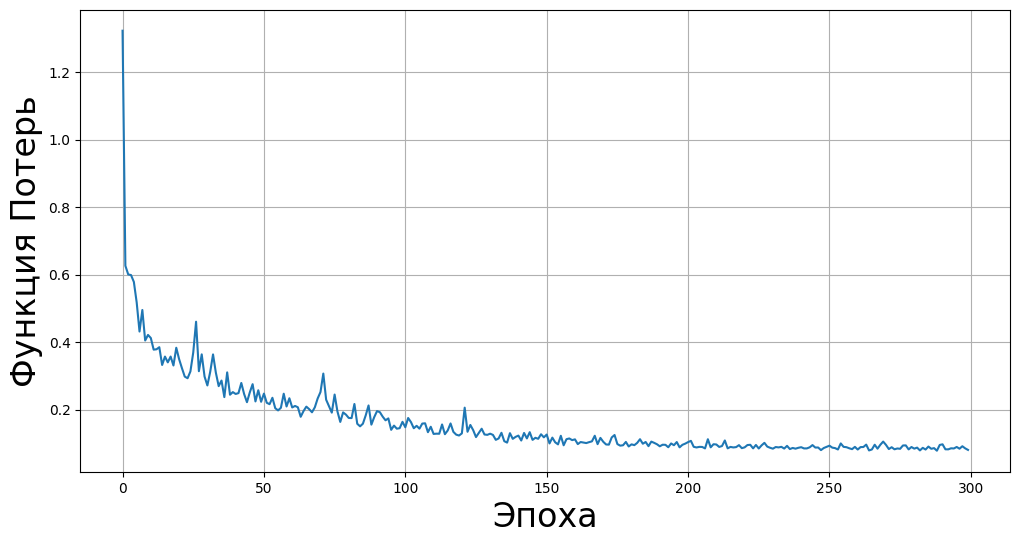

In [159]:
regr_l2 = RidgeRegression(
                       X = x_train,
                       learning_rate=0.25,
                       epochs=300, batch_size=10,
                       l2_penalty = 0.001)
regr_l2.fit(x_train_, y_train)

print(f'Test Score = {regr_l2.score(x_test_, y_test):.2f}, Train Score = {regr_l2.score(x_train_, y_train):.2f}')
regr_l2.plot_cost()

In [160]:
w, b = regr_l2.get_w_and_b()
print(w,b)

[ 5.4568901  -0.31919438 -2.5264715  -2.55100074 -2.46637139 -1.50659708
  0.0698673   0.74870062  1.18956599  2.23422861] -1.2891362141228055


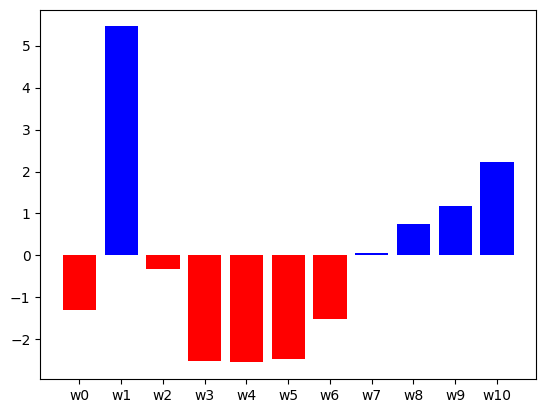

In [161]:
vis_weigths(np.hstack([b,w]))

In [162]:
np.sum(np.abs(w))

19.06888769367351

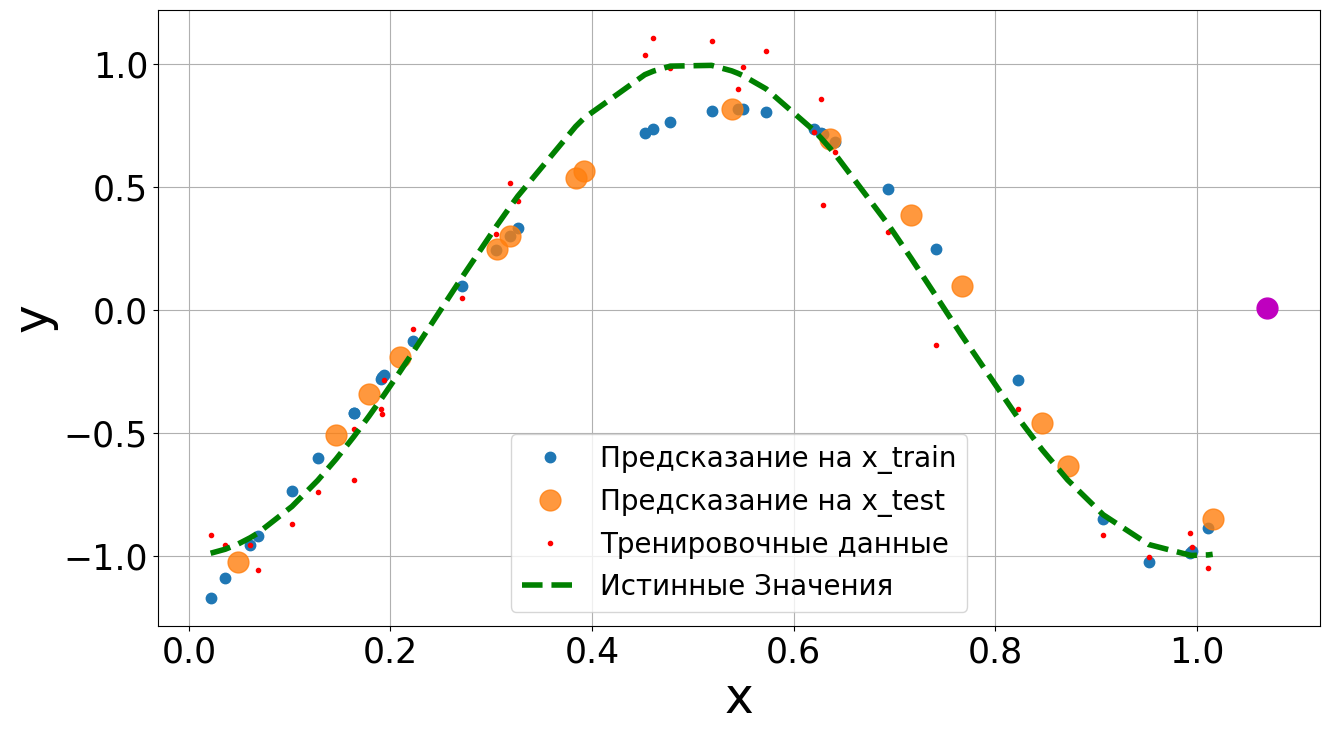

In [163]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l2)

plt.plot([1.07], 
         regr_l2.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

### Регуляризация L1
В ряде случаев, когда разброс данных оказывается очень большим, регуляризации L2 может оказаться бесполезной или даже вредной. Дело в том, что в функции потерь мы учитываем веса в квадрате и большие колебания весовых параметров приведут к большим колебаниям в значениях функции потерь. Часто эта ситуация является недопустимой. 

В таких случаях следует выбирать более устойчивые (робастные методы). Робастные методы могут быть менее точными, однако более стабильными. Одним из наиболее распространённых робастных методов является L1 регуляризация. В этом случае выражение для функции потерь может быть записано следующим образом:
$$ \begin{cases}
L(\hat{y}_i,y_i)\to \min \\
\| W \|_1^1 <\mathrm{const}
\end{cases}
\to L(\hat{y}_i,y_i) + \frac{\lambda}{2}\sum_{j=1}^{p} W_j\to \min,
$$
где  
- $\| W \|_1^1 = \sum_{j=1}^{p} |W_j|$ - норма L1 для вектора или матрицы;
- $\lambda $   - регуляризационный множитель;  
- $p$ - размер вектора весовых параметров;
 
Закон изменения весовых параметров для данной модели можно зписать как:
$$ W^t = W^{t-1}-\eta\left(\frac{1}{N}\sum_{i=0}^{N-1}\nabla_{W}L(\hat{y}_i,y_i) + \lambda*sign(W^{t-1})\right). $$
Запишем новую версию регрессии. Для этого запишем новый класс, наследующий от уже созданного и перепишем в нем методы `loss`     и `update`.

In [164]:
class LassoRegression(LinearRegression):
    def __init__(self,
                X,
                learning_rate = 0.5,
                l1_penalty = 0.001,
                epochs = 100, 
                weights = None, 
                bias    = None, 
                batch_size   = 1000,
                n_batches    = None,
                random_state = 42):
        
        super().__init__(
                        X=X,
                        learning_rate = learning_rate,
                        epochs = epochs, 
                        weights = weights, 
                        bias    = bias, 
                        batch_size   = batch_size, 
                        n_batches    = n_batches,
                        random_state = random_state)
        self.l1_penalty = l1_penalty
    
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term
                  
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*(self.grad + np.sign(self.weights)*self.l1_penalty)

Test Score = 0.79, Train Score = 0.86


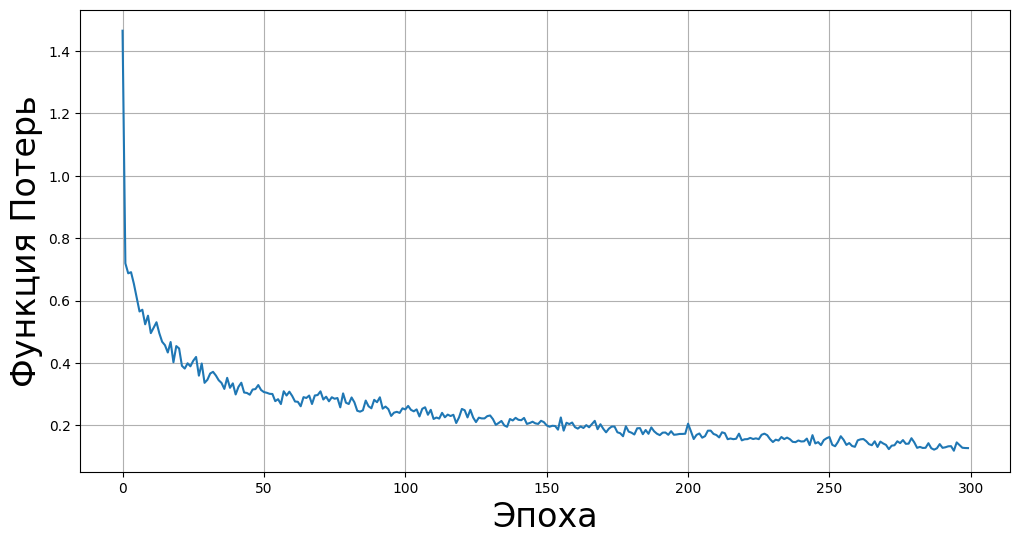

In [166]:
regr_l1 = LassoRegression(
                    X = x_train,
                    learning_rate=0.1,
                    epochs=300,batch_size=10,
                    l1_penalty = 0.001)
regr_l1.fit(x_train_, y_train)

print(f'Test Score = {regr_l1.score(x_test_, y_test):.2f}, Train Score = {regr_l1.score(x_train_, y_train):.2f}')
regr_l1.plot_cost()

In [167]:
w, b = regr_l1.get_w_and_b()
print(w,b)

[ 3.88674506 -0.02553245 -1.31063996 -1.38550494 -1.6403498  -1.1334317
 -0.00955853  0.20494101  0.33425247  1.02204273] -0.9995536602834406


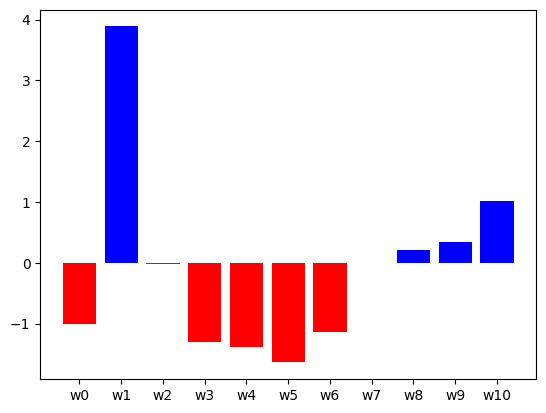

In [168]:
vis_weigths(np.hstack([b,w]))

In [169]:
np.sum(np.abs(w))

10.952998642294357

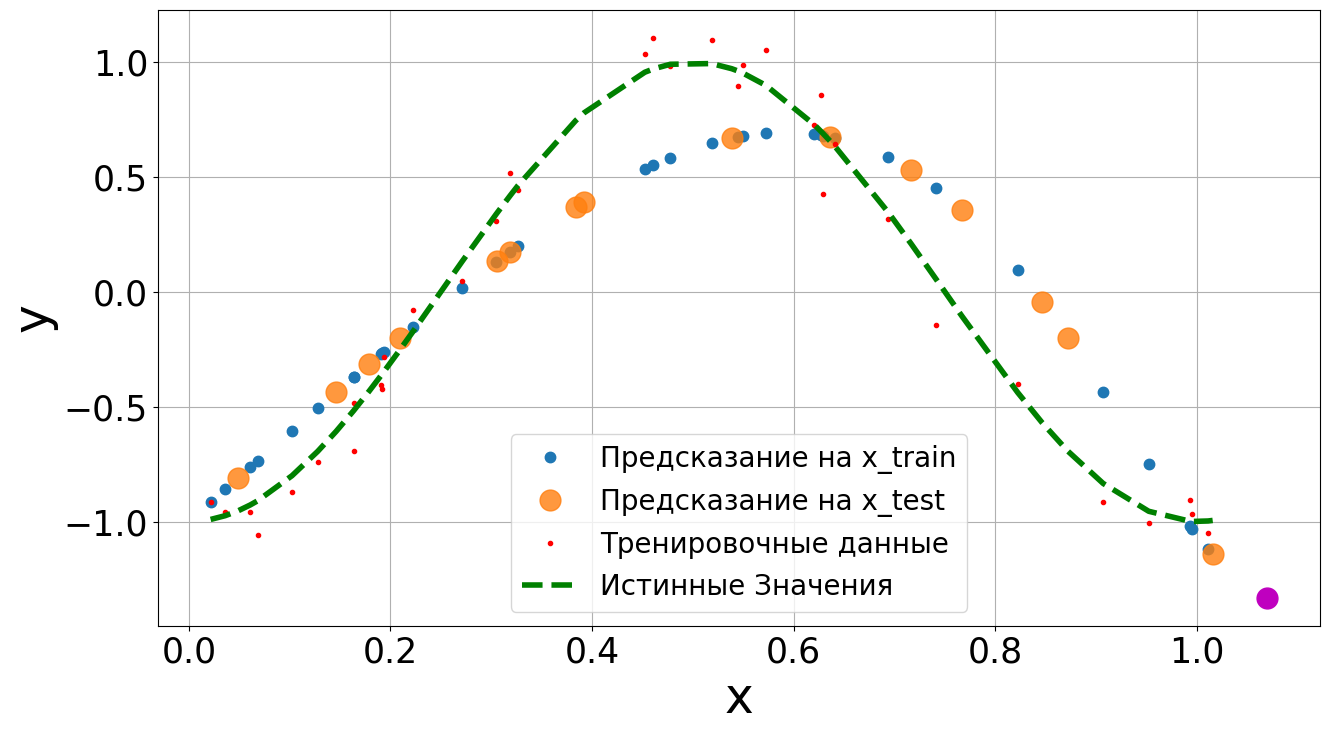

In [170]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1)

plt.plot([1.07], 
         regr_l1.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );

### Эластичная регуляризация
Отметим, что во многих случаях неизвестно какая модель регуляризации окажется лучше, поэтому целесообразно использовать их обе вместе. Такая модель регуляризации называется эластической регуляризацией. Попробуем ее реализовать

In [171]:
class ElasticRegression(LinearRegression):
    def __init__(self,
                X,
                learning_rate = 0.5,
                l1_penalty = 0.0,
                l2_penalty = 0.0,
                epochs = 100, 
                weights = None, 
                bias    = None, 
                batch_size   = 1000, 
                n_batches    = None,
                random_state = 42):
        
        super().__init__(
                        X = X,
                        learning_rate = learning_rate,
                        epochs = epochs, 
                        weights = weights, 
                        bias    = bias, 
                        batch_size   = batch_size, 
                        n_batches    = n_batches,
                        random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

Test Score = 0.80, Train Score = 0.87


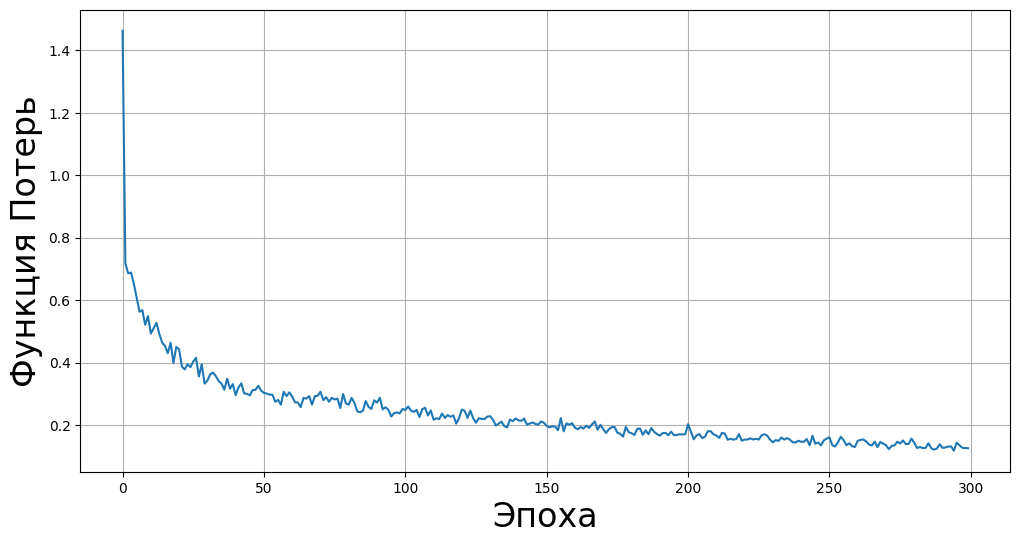

In [173]:
regr_l1l2 = ElasticRegression(
                        X = x_train,
                        learning_rate=0.1,
                        epochs=300,batch_size=10,
                        l1_penalty = 0.0001,l2_penalty = 0.001)
regr_l1l2.fit(x_train_, y_train)

print(f'Test Score = {regr_l1l2.score(x_test_, y_test):.2f}, Train Score = {regr_l1l2.score(x_train_, y_train):.2f}')
regr_l1l2.plot_cost()

In [174]:
w, b = regr_l1l2.get_w_and_b()
print(w,b)

[ 3.92008426  0.03235775 -1.3787937  -1.42837648 -1.69711616 -1.18349794
 -0.04187663  0.24588499  0.36211507  1.12587409] -1.0090541478031452


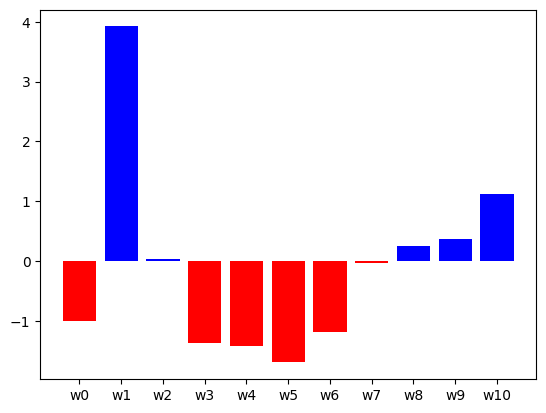

In [175]:
vis_weigths(np.hstack([b,w]))

In [176]:
np.sum(np.abs(w))

11.415977077611505

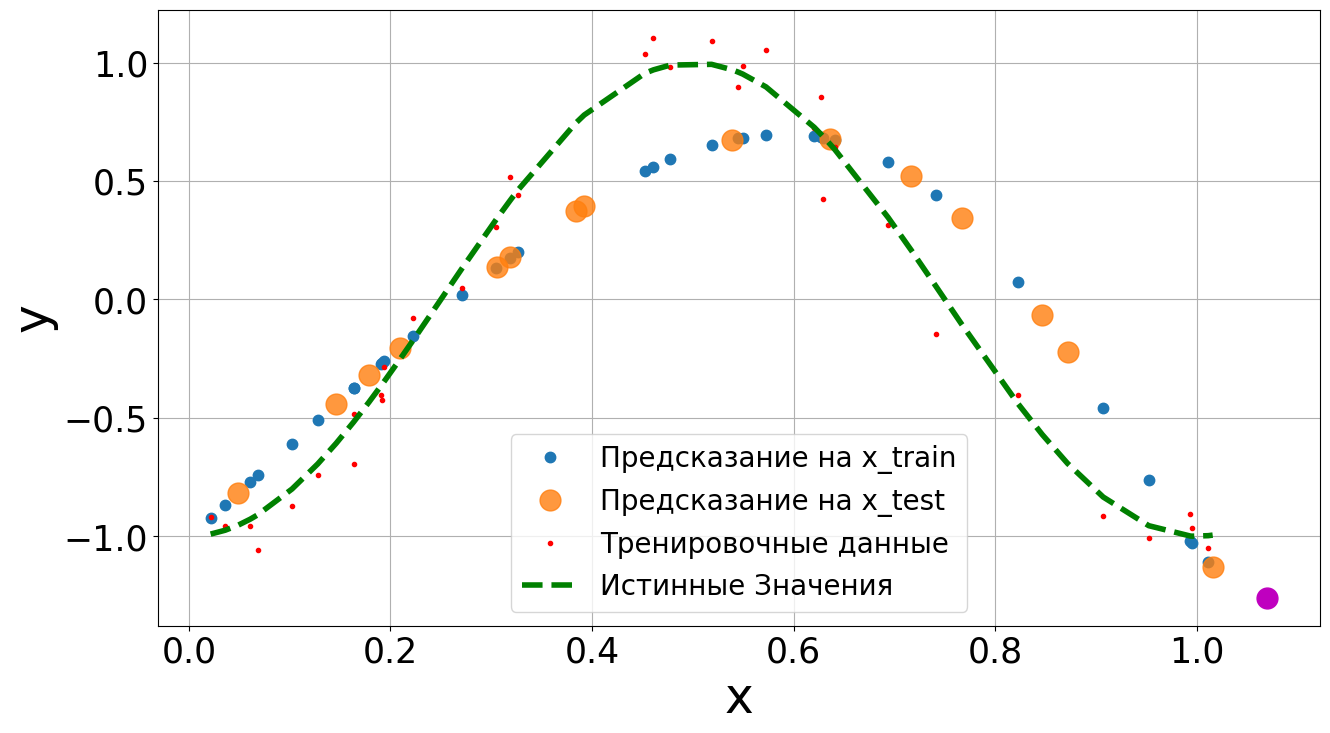

In [177]:
plt.figure(figsize=(15,8))

plot_model_class(x_train_, y_train, x_test_, x, y_true, regr_l1l2)

plt.plot([1.07], 
         regr_l1l2.predict(to_polynom([1.07], order=order)) ,
         'mo',  label = 'new predict',
        markersize = 15 );